In [1]:
%load_ext autoreload
%autoreload 2

import random
import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam

import activation
import cpn_model
import config
import lesion
import michaels_load
import mRNN
import observer
import stim
import stim_model
import utils


OBSERVER_TYPE = observer.ObserverType.gaussian
STIMULATION_TYPE = stim.StimulationType.gaussian_exp
CPN_ACTIVATION_TYPE = activation.ActivationType.Tanh
EN_ACTIVATION_TYPE = activation.ActivationType.Tanh
LESION_TYPE = lesion.LesionType.connection
OBS_OUT_DIM = 20
OBS_SIGMA = 1.75
NUM_STIM_CHANNELS = 16
STIM_SIGMA = 2.175
BATCH_SIZE = 128
KFOLDS = 5
CUDA = torch.device(0)

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, \
        run_type_str, run_type_str_short, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              obs_out_dim=OBS_OUT_DIM,
                                              obs_sigma=OBS_SIGMA,
                                              cuda=CUDA)


MODEL_OUT_DIR = "models"
LOG_OUT_DIR = "logs"

print("Run config:", run_type_str)
print(run_type_str_short)

Run config: gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2)]_gaussianExp16.2.175_enActTanh_cpnActTanh
obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh


In [2]:
# Set up the Michaels mRNN

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path())

if CUDA:
    mike.cuda()
    
mike.set_lesion(lesion_instance)
mike.reset()

In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(), with_label=True,
                              cuda=CUDA)

probs = torch.ones(len(dataset)) / float(len(dataset))
holdout_count = int(len(dataset) / KFOLDS)
holdout_idxs = set([p.item() for p in probs.multinomial(num_samples=holdout_count)])

train = []
test = []
for idx in range(len(dataset)):
    if idx in holdout_idxs:
        test.append(dataset[idx])
    else:
        train.append(dataset[idx])

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_train = DataLoader(
  train, batch_size=len(train), shuffle=True
)
loader_test = DataLoader(
  test, batch_size=len(test), shuffle=True
)


torch.Size([341, 1])


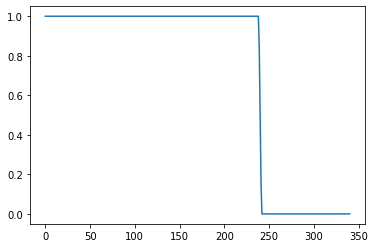

In [4]:
# Hold signal is in the last position
plt.plot(dataset[0][0][:, -1:].cpu().detach().numpy())
print(dataset[0][0][:, -1:].shape)
plt.show()

In [8]:
# Question: can we separate the classes before movement onset?

loss = nn.CrossEntropyLoss()
model = utils.LSTMModel(2*OBS_OUT_DIM, 42, num_neurons=40,
                       cuda=CUDA)

opt = AdamW(model.parameters(), lr=1e-3)#, weight_decay=0.04)
ll = 1

for param in mike.parameters():
    param.requires_grad=False

    
def unroll(model, mike, observer, din, shift=50, cuda=None):
    mike.reset()
    model.reset()
    
    dhold = din[:, :, -1:]
    batch_size = din.shape[0]
    steps = 250

    for tidx in range(steps):
        mike_in = din[:, tidx, :].T
        mike(mike_in)         
            
        if tidx < shift:
            cur_hold = torch.ones(din[:, tidx, -1:].shape)
            if cuda:
                cur_hold = cur_hold.cuda(cuda)
        else:
            cur_hold = din[:, tidx-shift, -1:]
            
        obs = mike.observe(observer)
        new_obs = torch.cat(obs[1:], axis=1)
        
        new_obs = new_obs * cur_hold
        
        pred = model(new_obs)
        
    return pred
        
eidx = 0
losses = []
test_losses = []
bail = False
while True:
    for batch in loader_train:
        if ll >= 1.8:
            for p in opt.param_groups:
                p['lr'] = 1e-3
        elif ll < 1.8:
            for p in opt.param_groups:
                p['lr'] = 1e-4
        elif ll < 1.3:
            for p in opt.param_groups:
                p['lr'] = 5e-5
        elif ll < 1:
            for p in opt.param_groups:
                p['lr'] = 3e-5
        
        din, trial_end, trial_len, dout, dlabel = batch
        batch_size = din.shape[0]
        opt.zero_grad() 
 
        pred = unroll(model, mike, observer, din, cuda=CUDA)
                
        la = loss(pred, dlabel)

        ll = la.item()
        la.backward()
        opt.step()
        losses.append(ll)
        
        correct = 0
        for x in range(batch_size):
            m = torch.argmax(pred[x, :])
            if m == dlabel[x]:
                correct += 1
                
        
        batch_test = next(iter(loader_test))
        din_test, trial_end_test, trial_len_test, dout_test, dlabel_test = batch_test
        batch_size_test = din_test.shape[0]
        pred_test = unroll(model, mike, observer, din_test, cuda=CUDA)
            
        rl = loss(pred_test, dlabel_test)
        rli = rl.item()
        test_losses.append(rli)
        
        correct_test = 0
        for x in range(batch_size_test):
            m = torch.argmax(pred_test[x, :])
            if m == dlabel_test[x]:
                correct_test += 1

        print(eidx, f"{correct}/{batch_size}", ll, f"test: {correct_test}/{batch_size_test}")
        
        if (correct / batch_size) >= 0.995:
            bail = True
            break
        
        
        eidx += 1
    if bail:
        break
        


0 10/402 3.7414779663085938 test: 2/100
1 10/402 3.741381883621216 test: 2/100
2 10/402 3.7404417991638184 test: 2/100
3 10/402 3.739551544189453 test: 2/100
4 10/402 3.7387025356292725 test: 2/100
5 10/402 3.7378885746002197 test: 2/100
6 10/402 3.7371041774749756 test: 2/100
7 10/402 3.736342191696167 test: 2/100
8 10/402 3.7355942726135254 test: 2/100
9 10/402 3.734856605529785 test: 2/100
10 10/402 3.734126091003418 test: 2/100
11 10/402 3.7333977222442627 test: 2/100
12 10/402 3.7326672077178955 test: 2/100
13 10/402 3.731931686401367 test: 2/100
14 10/402 3.731187582015991 test: 2/100
15 10/402 3.7304322719573975 test: 2/100
16 10/402 3.729666233062744 test: 2/100
17 10/402 3.7288808822631836 test: 2/100
18 10/402 3.7280781269073486 test: 2/100
19 10/402 3.727255344390869 test: 2/100
20 10/402 3.726407527923584 test: 2/100
21 12/402 3.7255289554595947 test: 1/100
22 12/402 3.7246100902557373 test: 1/100
23 11/402 3.723646402359009 test: 1/100
24 11/402 3.7226219177246094 test: 1/

200 13/402 3.646582841873169 test: 1/100
201 14/402 3.641516923904419 test: 1/100
202 14/402 3.6361916065216064 test: 1/100
203 15/402 3.6306300163269043 test: 1/100
204 19/402 3.6245813369750977 test: 1/100
205 21/402 3.6179568767547607 test: 1/100
206 27/402 3.61035418510437 test: 1/100
207 30/402 3.60109543800354 test: 2/100
208 31/402 3.588658571243286 test: 1/100
209 30/402 3.569409132003784 test: 1/100
210 34/402 3.5402731895446777 test: 2/100
211 37/402 3.4984052181243896 test: 5/100
212 51/402 3.404431104660034 test: 4/100
213 38/402 3.3570666313171387 test: 4/100
214 35/402 3.354948043823242 test: 4/100
215 24/402 3.388493537902832 test: 4/100
216 32/402 3.377124071121216 test: 4/100
217 35/402 3.333070993423462 test: 4/100
218 45/402 3.292956590652466 test: 6/100
219 70/402 3.2619152069091797 test: 3/100
220 64/402 3.2667226791381836 test: 4/100
221 59/402 3.259263277053833 test: 3/100
222 54/402 3.2540483474731445 test: 3/100
223 56/402 3.249563455581665 test: 4/100
224 57/4

399 22/402 3.463071823120117 test: 2/100
400 22/402 3.4558393955230713 test: 2/100
401 22/402 3.448751449584961 test: 2/100
402 22/402 3.441864252090454 test: 3/100
403 24/402 3.4353535175323486 test: 3/100
404 24/402 3.429264545440674 test: 3/100
405 24/402 3.4236841201782227 test: 3/100
406 24/402 3.418750047683716 test: 3/100
407 24/402 3.4145126342773438 test: 3/100
408 25/402 3.4109277725219727 test: 3/100
409 25/402 3.4079055786132812 test: 3/100
410 27/402 3.4052071571350098 test: 3/100
411 28/402 3.4027130603790283 test: 3/100
412 31/402 3.4003231525421143 test: 3/100
413 31/402 3.397897958755493 test: 3/100
414 31/402 3.3952534198760986 test: 3/100
415 32/402 3.3923020362854004 test: 3/100
416 32/402 3.389084815979004 test: 3/100
417 32/402 3.3855268955230713 test: 3/100
418 32/402 3.381696939468384 test: 3/100
419 33/402 3.377580165863037 test: 3/100
420 35/402 3.373305320739746 test: 3/100
421 34/402 3.369014024734497 test: 3/100
422 34/402 3.364804983139038 test: 3/100
423 

597 90/402 2.627992868423462 test: 11/100
598 81/402 2.6361420154571533 test: 10/100
599 73/402 2.6538705825805664 test: 11/100
600 83/402 2.641056776046753 test: 13/100
601 89/402 2.6209447383880615 test: 12/100
602 101/402 2.621619462966919 test: 13/100
603 102/402 2.6145763397216797 test: 14/100
604 93/402 2.6053903102874756 test: 13/100
605 83/402 2.6076982021331787 test: 14/100
606 87/402 2.599177360534668 test: 11/100
607 88/402 2.5964415073394775 test: 10/100
608 83/402 2.5883870124816895 test: 11/100
609 84/402 2.5999491214752197 test: 10/100
610 88/402 2.6132090091705322 test: 10/100
611 81/402 2.5808963775634766 test: 8/100
612 74/402 2.5942041873931885 test: 9/100
613 88/402 2.573042154312134 test: 13/100
614 94/402 2.5670857429504395 test: 11/100
615 90/402 2.5763168334960938 test: 8/100
616 88/402 2.566497564315796 test: 11/100
617 86/402 2.5508992671966553 test: 11/100
618 91/402 2.5543665885925293 test: 12/100
619 88/402 2.5487756729125977 test: 10/100
620 89/402 2.55463

794 38/402 3.076019763946533 test: 3/100
795 41/402 3.075857400894165 test: 3/100
796 41/402 3.0723843574523926 test: 3/100
797 43/402 3.0686044692993164 test: 3/100
798 44/402 3.067781448364258 test: 4/100
799 45/402 3.0653586387634277 test: 4/100
800 47/402 3.061532497406006 test: 4/100
801 47/402 3.0597822666168213 test: 4/100
802 49/402 3.0580592155456543 test: 4/100
803 49/402 3.0548579692840576 test: 4/100
804 51/402 3.0525548458099365 test: 4/100
805 51/402 3.0510456562042236 test: 4/100
806 51/402 3.048208475112915 test: 4/100
807 51/402 3.0457262992858887 test: 4/100
808 53/402 3.043945074081421 test: 4/100
809 53/402 3.0415780544281006 test: 4/100
810 53/402 3.0389890670776367 test: 4/100
811 53/402 3.0369443893432617 test: 4/100
812 53/402 3.035057544708252 test: 4/100
813 53/402 3.0323264598846436 test: 4/100
814 48/402 3.030324697494507 test: 4/100
815 47/402 3.0283122062683105 test: 4/100
816 46/402 3.025817632675171 test: 4/100
817 46/402 3.0235941410064697 test: 4/100
8

991 23/402 4.242043972015381 test: 1/100
992 11/402 4.750558376312256 test: 1/100
993 11/402 4.960577487945557 test: 1/100
994 11/402 5.158740997314453 test: 1/100
995 11/402 5.237681865692139 test: 1/100
996 11/402 5.256307601928711 test: 1/100
997 11/402 5.2404632568359375 test: 1/100
998 11/402 5.203089237213135 test: 1/100
999 11/402 5.15088415145874 test: 1/100
1000 22/402 5.087792873382568 test: 2/100
1001 22/402 5.017599105834961 test: 2/100
1002 22/402 4.941491603851318 test: 2/100
1003 22/402 4.862204074859619 test: 2/100
1004 22/402 4.780928611755371 test: 1/100
1005 20/402 4.69923210144043 test: 1/100
1006 18/402 4.6177520751953125 test: 1/100
1007 17/402 4.537822246551514 test: 1/100
1008 17/402 4.460183143615723 test: 1/100
1009 17/402 4.385913372039795 test: 1/100
1010 18/402 4.315526962280273 test: 1/100
1011 19/402 4.2491536140441895 test: 1/100
1012 27/402 4.187664985656738 test: 3/100
1013 25/402 4.1305623054504395 test: 5/100
1014 30/402 4.077888488769531 test: 6/100

1183 92/402 2.413783311843872 test: 13/100
1184 90/402 2.410112142562866 test: 13/100
1185 90/402 2.4065442085266113 test: 13/100
1186 89/402 2.4030771255493164 test: 13/100
1187 89/402 2.3994698524475098 test: 13/100
1188 88/402 2.396160125732422 test: 13/100
1189 89/402 2.3925464153289795 test: 13/100
1190 90/402 2.389103412628174 test: 13/100
1191 90/402 2.3860814571380615 test: 13/100
1192 89/402 2.3823862075805664 test: 13/100
1193 89/402 2.3785645961761475 test: 13/100
1194 89/402 2.374828338623047 test: 13/100
1195 88/402 2.3711001873016357 test: 13/100
1196 88/402 2.367541790008545 test: 13/100
1197 91/402 2.3638484477996826 test: 11/100
1198 91/402 2.360300302505493 test: 14/100
1199 91/402 2.358304500579834 test: 8/100
1200 55/402 2.755849599838257 test: 8/100
1201 58/402 2.8757691383361816 test: 9/100
1202 58/402 2.9375 test: 6/100
1203 56/402 3.0315916538238525 test: 5/100
1204 45/402 3.0086255073547363 test: 8/100
1205 55/402 2.82940411567688 test: 4/100
1206 51/402 2.7739

1370 143/402 1.978249430656433 test: 18/100
1371 145/402 1.9717236757278442 test: 18/100
1372 147/402 1.965640664100647 test: 21/100
1373 150/402 1.9618679285049438 test: 21/100
1374 146/402 1.962759256362915 test: 21/100
1375 147/402 1.9629849195480347 test: 20/100
1376 146/402 1.9625415802001953 test: 22/100
1377 149/402 1.9553065299987793 test: 22/100
1378 153/402 1.9509797096252441 test: 22/100
1379 138/402 1.9630589485168457 test: 20/100
1380 144/402 1.9531527757644653 test: 20/100
1381 141/402 1.9563535451889038 test: 24/100
1382 152/402 1.9444217681884766 test: 25/100
1383 146/402 1.94452965259552 test: 20/100
1384 144/402 1.942694067955017 test: 20/100
1385 145/402 1.936039686203003 test: 26/100
1386 143/402 1.9396778345108032 test: 23/100
1387 139/402 1.9392549991607666 test: 18/100
1388 135/402 1.950419545173645 test: 23/100
1389 153/402 1.9243701696395874 test: 22/100
1390 130/402 1.9526023864746094 test: 20/100
1391 150/402 1.9246619939804077 test: 19/100
1392 143/402 1.933

1554 172/402 1.754576325416565 test: 30/100
1555 175/402 1.7545331716537476 test: 30/100
1556 175/402 1.7543108463287354 test: 30/100
1557 174/402 1.753847360610962 test: 29/100
1558 171/402 1.7533347606658936 test: 28/100
1559 171/402 1.7538319826126099 test: 26/100
1560 174/402 1.7536523342132568 test: 26/100
1561 173/402 1.7534303665161133 test: 26/100
1562 173/402 1.7531867027282715 test: 26/100
1563 174/402 1.7528554201126099 test: 26/100
1564 174/402 1.752503752708435 test: 27/100
1565 174/402 1.7521713972091675 test: 27/100
1566 170/402 1.751886010169983 test: 28/100
1567 169/402 1.7516134977340698 test: 28/100
1568 171/402 1.7506352663040161 test: 28/100
1569 170/402 1.7505345344543457 test: 28/100
1570 168/402 1.7501171827316284 test: 27/100
1571 169/402 1.7497785091400146 test: 26/100
1572 171/402 1.7494546175003052 test: 26/100
1573 171/402 1.7500945329666138 test: 26/100
1574 171/402 1.749964952468872 test: 26/100
1575 172/402 1.749753713607788 test: 26/100
1576 172/402 1.7

1737 187/402 1.7090985774993896 test: 31/100
1738 188/402 1.708849549293518 test: 31/100
1739 187/402 1.708605408668518 test: 31/100
1740 187/402 1.7083640098571777 test: 31/100
1741 187/402 1.7081295251846313 test: 31/100
1742 187/402 1.7078652381896973 test: 31/100
1743 187/402 1.7076349258422852 test: 31/100
1744 187/402 1.7073925733566284 test: 31/100
1745 187/402 1.7071561813354492 test: 31/100
1746 187/402 1.7068901062011719 test: 31/100
1747 187/402 1.7066738605499268 test: 31/100
1748 187/402 1.7064170837402344 test: 31/100
1749 188/402 1.7061702013015747 test: 31/100
1750 188/402 1.7059352397918701 test: 31/100
1751 188/402 1.7057052850723267 test: 31/100
1752 188/402 1.7054316997528076 test: 31/100
1753 189/402 1.705208659172058 test: 31/100
1754 188/402 1.7049589157104492 test: 31/100
1755 189/402 1.7047135829925537 test: 31/100
1756 189/402 1.7044823169708252 test: 31/100
1757 188/402 1.7042229175567627 test: 32/100
1758 189/402 1.7039716243743896 test: 32/100
1759 189/402 

1921 193/402 1.663376808166504 test: 29/100
1922 193/402 1.663153052330017 test: 29/100
1923 192/402 1.6629151105880737 test: 29/100
1924 193/402 1.6626648902893066 test: 29/100
1925 193/402 1.6624245643615723 test: 29/100
1926 192/402 1.6621516942977905 test: 29/100
1927 193/402 1.661929726600647 test: 29/100
1928 193/402 1.661670446395874 test: 29/100
1929 192/402 1.6613980531692505 test: 29/100
1930 193/402 1.6611484289169312 test: 29/100
1931 193/402 1.660897135734558 test: 29/100
1932 193/402 1.6606512069702148 test: 29/100
1933 194/402 1.660404920578003 test: 29/100
1934 192/402 1.6601544618606567 test: 29/100
1935 192/402 1.6599410772323608 test: 29/100
1936 193/402 1.6596542596817017 test: 29/100
1937 193/402 1.6594239473342896 test: 29/100
1938 193/402 1.659157633781433 test: 29/100
1939 193/402 1.6588844060897827 test: 29/100
1940 194/402 1.6586326360702515 test: 29/100
1941 194/402 1.6583839654922485 test: 29/100
1942 194/402 1.6581645011901855 test: 29/100
1943 194/402 1.65

2105 197/402 1.6174323558807373 test: 29/100
2106 198/402 1.6171880960464478 test: 30/100
2107 199/402 1.6169500350952148 test: 30/100
2108 197/402 1.6166757345199585 test: 30/100
2109 197/402 1.6164205074310303 test: 30/100
2110 198/402 1.6161655187606812 test: 30/100
2111 199/402 1.6159225702285767 test: 29/100
2112 198/402 1.615671992301941 test: 29/100
2113 199/402 1.6154154539108276 test: 29/100
2114 198/402 1.6151663064956665 test: 30/100
2115 199/402 1.614914059638977 test: 30/100
2116 199/402 1.6146632432937622 test: 30/100
2117 200/402 1.6144083738327026 test: 29/100
2118 199/402 1.6141551733016968 test: 30/100
2119 199/402 1.6139017343521118 test: 31/100
2120 199/402 1.6136523485183716 test: 30/100
2121 199/402 1.6134049892425537 test: 31/100
2122 199/402 1.613137125968933 test: 30/100
2123 200/402 1.6128774881362915 test: 31/100
2124 200/402 1.6126124858856201 test: 31/100
2125 200/402 1.6123484373092651 test: 30/100
2126 201/402 1.612109899520874 test: 30/100
2127 201/402 1

2288 209/402 1.5699390172958374 test: 35/100
2289 211/402 1.5696830749511719 test: 35/100
2290 211/402 1.5694295167922974 test: 35/100
2291 211/402 1.569128394126892 test: 34/100
2292 210/402 1.5688725709915161 test: 34/100
2293 210/402 1.5686347484588623 test: 35/100
2294 210/402 1.5683314800262451 test: 35/100
2295 211/402 1.5680599212646484 test: 34/100
2296 211/402 1.56779944896698 test: 34/100
2297 211/402 1.567528247833252 test: 34/100
2298 210/402 1.567273497581482 test: 35/100
2299 211/402 1.5669828653335571 test: 35/100
2300 210/402 1.5667465925216675 test: 35/100
2301 210/402 1.5664790868759155 test: 34/100
2302 212/402 1.5662227869033813 test: 34/100
2303 212/402 1.5659807920455933 test: 35/100
2304 210/402 1.5656743049621582 test: 35/100
2305 210/402 1.5654078722000122 test: 34/100
2306 211/402 1.565140724182129 test: 35/100
2307 212/402 1.5648547410964966 test: 35/100
2308 210/402 1.5645867586135864 test: 35/100
2309 210/402 1.564342737197876 test: 35/100
2310 212/402 1.56

2472 221/402 1.520277976989746 test: 38/100
2473 221/402 1.5200188159942627 test: 39/100
2474 224/402 1.5197269916534424 test: 39/100
2475 222/402 1.5194728374481201 test: 39/100
2476 223/402 1.519167423248291 test: 40/100
2477 226/402 1.5189182758331299 test: 40/100
2478 223/402 1.5186582803726196 test: 39/100
2479 223/402 1.5183647871017456 test: 39/100
2480 224/402 1.5180808305740356 test: 39/100
2481 224/402 1.5178073644638062 test: 40/100
2482 225/402 1.5175410509109497 test: 38/100
2483 223/402 1.5173031091690063 test: 40/100
2484 224/402 1.5170220136642456 test: 39/100
2485 224/402 1.5167579650878906 test: 38/100
2486 223/402 1.516484022140503 test: 38/100
2487 224/402 1.516203761100769 test: 41/100
2488 224/402 1.515963077545166 test: 39/100
2489 224/402 1.5156506299972534 test: 39/100
2490 223/402 1.5154036283493042 test: 41/100
2491 225/402 1.5151034593582153 test: 41/100
2492 227/402 1.5149224996566772 test: 40/100
2493 223/402 1.5146067142486572 test: 38/100
2494 224/402 1.

2656 233/402 1.4698238372802734 test: 42/100
2657 234/402 1.469535231590271 test: 42/100
2658 233/402 1.4692970514297485 test: 42/100
2659 233/402 1.468966007232666 test: 42/100
2660 235/402 1.468788743019104 test: 42/100
2661 233/402 1.4683889150619507 test: 42/100
2662 232/402 1.4681891202926636 test: 43/100
2663 233/402 1.4678210020065308 test: 42/100
2664 234/402 1.4676181077957153 test: 42/100
2665 233/402 1.4673157930374146 test: 42/100
2666 233/402 1.4670647382736206 test: 42/100
2667 235/402 1.4668079614639282 test: 42/100
2668 233/402 1.466423511505127 test: 42/100
2669 232/402 1.4662809371948242 test: 42/100
2670 235/402 1.4659292697906494 test: 42/100
2671 233/402 1.4656054973602295 test: 42/100
2672 234/402 1.4653874635696411 test: 41/100
2673 234/402 1.4650416374206543 test: 42/100
2674 234/402 1.464764952659607 test: 41/100
2675 233/402 1.4644842147827148 test: 41/100
2676 233/402 1.4641811847686768 test: 42/100
2677 233/402 1.4638700485229492 test: 41/100
2678 233/402 1.

2839 241/402 1.4188514947891235 test: 41/100
2840 241/402 1.418515682220459 test: 43/100
2841 242/402 1.4181119203567505 test: 43/100
2842 242/402 1.4179826974868774 test: 40/100
2843 242/402 1.418019413948059 test: 43/100
2844 241/402 1.4177429676055908 test: 43/100
2845 242/402 1.4170410633087158 test: 41/100
2846 242/402 1.416817545890808 test: 42/100
2847 242/402 1.4168440103530884 test: 42/100
2848 241/402 1.4165431261062622 test: 43/100
2849 241/402 1.4158711433410645 test: 43/100
2850 242/402 1.4156254529953003 test: 42/100
2851 242/402 1.4155200719833374 test: 43/100
2852 241/402 1.4151585102081299 test: 43/100
2853 241/402 1.414762258529663 test: 43/100
2854 243/402 1.4146385192871094 test: 43/100
2855 242/402 1.414387822151184 test: 43/100
2856 242/402 1.414004921913147 test: 43/100
2857 242/402 1.4136171340942383 test: 43/100
2858 242/402 1.4134386777877808 test: 43/100
2859 243/402 1.4132338762283325 test: 43/100
2860 241/402 1.4129271507263184 test: 43/100
2861 242/402 1.4

3022 243/402 1.36861252784729 test: 44/100
3023 244/402 1.3683511018753052 test: 44/100
3024 243/402 1.3680874109268188 test: 44/100
3025 244/402 1.367817997932434 test: 44/100
3026 243/402 1.367545485496521 test: 44/100
3027 243/402 1.3672404289245605 test: 44/100
3028 244/402 1.3670076131820679 test: 44/100
3029 244/402 1.3667129278182983 test: 44/100
3030 246/402 1.3665432929992676 test: 44/100
3031 244/402 1.3666131496429443 test: 43/100
3032 250/402 1.3664761781692505 test: 43/100
3033 245/402 1.3658136129379272 test: 43/100
3034 245/402 1.3654800653457642 test: 44/100
3035 248/402 1.365309476852417 test: 44/100
3036 243/402 1.36489737033844 test: 43/100
3037 244/402 1.364604115486145 test: 44/100
3038 247/402 1.364467740058899 test: 44/100
3039 243/402 1.3641436100006104 test: 44/100
3040 244/402 1.3638066053390503 test: 44/100
3041 248/402 1.3636367321014404 test: 43/100
3042 247/402 1.3633172512054443 test: 44/100
3043 245/402 1.3630043268203735 test: 44/100
3044 247/402 1.3627

3206 258/402 1.3198471069335938 test: 47/100
3207 260/402 1.3196684122085571 test: 46/100
3208 256/402 1.3195722103118896 test: 47/100
3209 260/402 1.3192964792251587 test: 46/100
3210 259/402 1.31882643699646 test: 46/100
3211 259/402 1.318601369857788 test: 47/100
3212 261/402 1.3187111616134644 test: 48/100
3213 253/402 1.318941593170166 test: 47/100
3214 262/402 1.3187332153320312 test: 46/100
3215 257/402 1.3176486492156982 test: 46/100
3216 256/402 1.3173476457595825 test: 47/100
3217 261/402 1.3172719478607178 test: 47/100
3218 259/402 1.3168898820877075 test: 46/100
3219 259/402 1.3164712190628052 test: 46/100
3220 259/402 1.3166483640670776 test: 46/100
3221 257/402 1.3159927129745483 test: 46/100
3222 259/402 1.315675139427185 test: 47/100
3223 260/402 1.315629482269287 test: 48/100
3224 257/402 1.3153492212295532 test: 47/100
3225 259/402 1.3148365020751953 test: 47/100
3226 260/402 1.3146973848342896 test: 47/100
3227 256/402 1.3148078918457031 test: 46/100
3228 261/402 1.3

3390 249/402 1.2796884775161743 test: 47/100
3391 242/402 1.289834976196289 test: 40/100
3392 225/402 1.3217034339904785 test: 47/100
3393 252/402 1.2772729396820068 test: 44/100
3394 239/402 1.2958431243896484 test: 41/100
3395 229/402 1.3432034254074097 test: 51/100
3396 261/402 1.2746360301971436 test: 43/100
3397 222/402 1.3358381986618042 test: 48/100
3398 263/402 1.2963565587997437 test: 46/100
3399 250/402 1.311374306678772 test: 43/100
3400 231/402 1.302625060081482 test: 46/100
3401 253/402 1.283577799797058 test: 44/100
3402 230/402 1.3137866258621216 test: 52/100
3403 270/402 1.2718795537948608 test: 44/100
3404 225/402 1.3039506673812866 test: 53/100
3405 268/402 1.2723867893218994 test: 46/100
3406 259/402 1.2964327335357666 test: 52/100
3407 264/402 1.2699593305587769 test: 43/100
3408 236/402 1.2929092645645142 test: 52/100
3409 274/402 1.2727524042129517 test: 48/100
3410 260/402 1.2898746728897095 test: 49/100
3411 253/402 1.2693971395492554 test: 47/100
3412 237/402 1

3574 274/402 1.2272071838378906 test: 51/100
3575 277/402 1.2269387245178223 test: 52/100
3576 274/402 1.226755142211914 test: 52/100
3577 273/402 1.2264869213104248 test: 52/100
3578 276/402 1.2262277603149414 test: 52/100
3579 277/402 1.2259961366653442 test: 52/100
3580 273/402 1.2257039546966553 test: 52/100
3581 272/402 1.225522756576538 test: 51/100
3582 275/402 1.2252029180526733 test: 52/100
3583 275/402 1.2250200510025024 test: 51/100
3584 276/402 1.2247692346572876 test: 52/100
3585 272/402 1.2245688438415527 test: 51/100
3586 275/402 1.2242558002471924 test: 52/100
3587 278/402 1.224008321762085 test: 53/100
3588 274/402 1.2238093614578247 test: 51/100
3589 276/402 1.2234489917755127 test: 51/100
3590 277/402 1.2233095169067383 test: 52/100
3591 275/402 1.2229970693588257 test: 52/100
3592 274/402 1.222758412361145 test: 52/100
3593 279/402 1.2225559949874878 test: 51/100
3594 276/402 1.2222845554351807 test: 52/100
3595 272/402 1.2221624851226807 test: 52/100
3596 278/402 1

3757 274/402 1.1801875829696655 test: 51/100
3758 278/402 1.179978847503662 test: 52/100
3759 276/402 1.1796571016311646 test: 53/100
3760 275/402 1.1791983842849731 test: 51/100
3761 277/402 1.1789560317993164 test: 51/100
3762 277/402 1.178617000579834 test: 53/100
3763 277/402 1.1785252094268799 test: 51/100
3764 275/402 1.178125023841858 test: 51/100
3765 276/402 1.1779884099960327 test: 51/100
3766 275/402 1.1775938272476196 test: 53/100
3767 276/402 1.1772128343582153 test: 51/100
3768 276/402 1.1769086122512817 test: 51/100
3769 276/402 1.1768189668655396 test: 53/100
3770 277/402 1.1766761541366577 test: 52/100
3771 275/402 1.176243782043457 test: 51/100
3772 276/402 1.1758452653884888 test: 53/100
3773 277/402 1.175813913345337 test: 52/100
3774 275/402 1.1753817796707153 test: 53/100
3775 278/402 1.1750798225402832 test: 52/100
3776 277/402 1.174784779548645 test: 52/100
3777 276/402 1.1743967533111572 test: 53/100
3778 278/402 1.1740930080413818 test: 53/100
3779 277/402 1.1

3940 288/402 1.126044750213623 test: 54/100
3941 288/402 1.1261121034622192 test: 54/100
3942 293/402 1.125611424446106 test: 54/100
3943 287/402 1.124145746231079 test: 54/100
3944 288/402 1.125175952911377 test: 53/100
3945 291/402 1.1244333982467651 test: 55/100
3946 288/402 1.1236920356750488 test: 54/100
3947 288/402 1.1239176988601685 test: 53/100
3948 289/402 1.1235536336898804 test: 55/100
3949 289/402 1.1227129697799683 test: 55/100
3950 288/402 1.122463345527649 test: 54/100
3951 287/402 1.1226476430892944 test: 54/100
3952 287/402 1.1215441226959229 test: 55/100
3953 287/402 1.121394157409668 test: 54/100
3954 289/402 1.1214390993118286 test: 55/100
3955 291/402 1.1220016479492188 test: 54/100
3956 291/402 1.1210618019104004 test: 55/100
3957 289/402 1.1203057765960693 test: 54/100
3958 289/402 1.1206477880477905 test: 54/100
3959 290/402 1.1199547052383423 test: 55/100
3960 288/402 1.1194579601287842 test: 54/100
3961 288/402 1.118917465209961 test: 54/100
3962 286/402 1.11

4123 292/402 1.096321702003479 test: 53/100
4124 292/402 1.0959316492080688 test: 52/100
4125 289/402 1.0948752164840698 test: 51/100
4126 287/402 1.0952301025390625 test: 52/100
4127 289/402 1.0944850444793701 test: 52/100
4128 292/402 1.094231128692627 test: 52/100
4129 293/402 1.093995213508606 test: 52/100
4130 290/402 1.0931919813156128 test: 54/100
4131 285/402 1.0931587219238281 test: 54/100
4132 286/402 1.0929136276245117 test: 52/100
4133 293/402 1.0923945903778076 test: 53/100
4134 293/402 1.0929486751556396 test: 52/100
4135 293/402 1.0921136140823364 test: 54/100
4136 285/402 1.0917521715164185 test: 54/100
4137 284/402 1.0914171934127808 test: 53/100
4138 289/402 1.0906530618667603 test: 52/100
4139 289/402 1.0907883644104004 test: 52/100
4140 290/402 1.0902156829833984 test: 53/100
4141 286/402 1.0896306037902832 test: 54/100
4142 287/402 1.089576244354248 test: 54/100
4143 289/402 1.0890141725540161 test: 54/100
4144 291/402 1.0887134075164795 test: 54/100
4145 291/402 1

4307 296/402 1.0495679378509521 test: 56/100
4308 296/402 1.0493379831314087 test: 56/100
4309 296/402 1.049191951751709 test: 56/100
4310 295/402 1.048911452293396 test: 56/100
4311 297/402 1.048691749572754 test: 56/100
4312 297/402 1.048502802848816 test: 56/100
4313 297/402 1.048256278038025 test: 56/100
4314 295/402 1.0480475425720215 test: 56/100
4315 296/402 1.0478006601333618 test: 56/100
4316 296/402 1.047688603401184 test: 56/100
4317 296/402 1.0474482774734497 test: 56/100
4318 295/402 1.047206997871399 test: 56/100
4319 295/402 1.0470383167266846 test: 56/100
4320 296/402 1.0468066930770874 test: 56/100
4321 294/402 1.046618103981018 test: 56/100
4322 295/402 1.0463757514953613 test: 56/100
4323 296/402 1.0461536645889282 test: 56/100
4324 296/402 1.0459415912628174 test: 56/100
4325 296/402 1.0457673072814941 test: 56/100
4326 295/402 1.0455420017242432 test: 56/100
4327 296/402 1.0453031063079834 test: 55/100
4328 296/402 1.0450520515441895 test: 55/100
4329 297/402 1.044

4491 302/402 1.0141968727111816 test: 56/100
4492 299/402 1.013965129852295 test: 56/100
4493 300/402 1.013737440109253 test: 56/100
4494 301/402 1.0136078596115112 test: 56/100
4495 304/402 1.0134018659591675 test: 56/100
4496 302/402 1.0131902694702148 test: 56/100
4497 301/402 1.0129886865615845 test: 56/100
4498 302/402 1.012726068496704 test: 56/100
4499 301/402 1.0125384330749512 test: 56/100
4500 302/402 1.0123392343521118 test: 56/100
4501 304/402 1.0121469497680664 test: 56/100
4502 301/402 1.0119327306747437 test: 56/100
4503 301/402 1.0116864442825317 test: 56/100
4504 302/402 1.011508822441101 test: 56/100
4505 303/402 1.0113215446472168 test: 56/100
4506 304/402 1.0111165046691895 test: 56/100
4507 301/402 1.0108979940414429 test: 56/100
4508 304/402 1.010707974433899 test: 56/100
4509 305/402 1.0105394124984741 test: 56/100
4510 300/402 1.010287880897522 test: 56/100
4511 300/402 1.0101280212402344 test: 56/100
4512 304/402 1.0099492073059082 test: 56/100
4513 304/402 1.0

4674 306/402 0.9772428274154663 test: 57/100
4675 307/402 0.9770240783691406 test: 57/100
4676 306/402 0.9768326282501221 test: 57/100
4677 306/402 0.9766151309013367 test: 57/100
4678 306/402 0.9765242338180542 test: 57/100
4679 307/402 0.9762126207351685 test: 57/100
4680 307/402 0.9761888384819031 test: 57/100
4681 307/402 0.975805938243866 test: 57/100
4682 306/402 0.9757043719291687 test: 57/100
4683 306/402 0.975365400314331 test: 57/100
4684 307/402 0.97520911693573 test: 57/100
4685 307/402 0.9750357866287231 test: 57/100
4686 307/402 0.9748789668083191 test: 57/100
4687 307/402 0.9745497107505798 test: 57/100
4688 307/402 0.9744293093681335 test: 57/100
4689 307/402 0.9741837382316589 test: 57/100
4690 307/402 0.9739509224891663 test: 57/100
4691 307/402 0.9738142490386963 test: 57/100
4692 307/402 0.9734381437301636 test: 57/100
4693 306/402 0.9735168814659119 test: 56/100
4694 306/402 0.9741321206092834 test: 57/100
4695 307/402 0.9737454056739807 test: 57/100
4696 306/402 0

4857 305/402 0.9540114998817444 test: 59/100
4858 309/402 0.9526227712631226 test: 58/100
4859 309/402 0.953025221824646 test: 58/100
4860 306/402 0.9503659009933472 test: 58/100
4861 300/402 0.9513824582099915 test: 56/100
4862 298/402 0.9505985975265503 test: 58/100
4863 307/402 0.947955846786499 test: 58/100
4864 307/402 0.9503899812698364 test: 58/100
4865 307/402 0.9490879774093628 test: 59/100
4866 303/402 0.9482916593551636 test: 58/100
4867 300/402 0.9480757117271423 test: 59/100
4868 305/402 0.9467779994010925 test: 59/100
4869 306/402 0.9473538398742676 test: 58/100
4870 306/402 0.9467235207557678 test: 58/100
4871 306/402 0.9457181096076965 test: 58/100
4872 306/402 0.9469574689865112 test: 59/100
4873 304/402 0.9450104236602783 test: 59/100
4874 306/402 0.9455086588859558 test: 59/100
4875 307/402 0.9446435570716858 test: 58/100
4876 304/402 0.9444078803062439 test: 58/100
4877 304/402 0.944383978843689 test: 58/100
4878 305/402 0.9434946775436401 test: 58/100
4879 306/402 

5040 309/402 0.9130180478096008 test: 59/100
5041 312/402 0.9115900993347168 test: 59/100
5042 311/402 0.9125812649726868 test: 57/100
5043 309/402 0.9116746187210083 test: 57/100
5044 308/402 0.9110864400863647 test: 58/100
5045 308/402 0.9116982221603394 test: 58/100
5046 313/402 0.9114269018173218 test: 59/100
5047 312/402 0.9107258319854736 test: 58/100
5048 307/402 0.9104073643684387 test: 58/100
5049 309/402 0.9106342196464539 test: 58/100
5050 311/402 0.909729540348053 test: 58/100
5051 315/402 0.9099629521369934 test: 59/100
5052 312/402 0.9097880125045776 test: 58/100
5053 312/402 0.909199059009552 test: 59/100
5054 311/402 0.9091359376907349 test: 58/100
5055 310/402 0.9089226126670837 test: 59/100
5056 311/402 0.9087736010551453 test: 59/100
5057 311/402 0.9084064960479736 test: 59/100
5058 310/402 0.9084470272064209 test: 59/100
5059 311/402 0.9079853296279907 test: 60/100
5060 311/402 0.907794177532196 test: 59/100
5061 312/402 0.907720148563385 test: 58/100
5062 311/402 0

5223 311/402 0.8775995969772339 test: 61/100
5224 312/402 0.8772907257080078 test: 62/100
5225 315/402 0.8772260546684265 test: 62/100
5226 311/402 0.8769559860229492 test: 62/100
5227 313/402 0.8766857385635376 test: 62/100
5228 314/402 0.87645423412323 test: 62/100
5229 315/402 0.8763337135314941 test: 62/100
5230 313/402 0.8760796785354614 test: 62/100
5231 311/402 0.8759474754333496 test: 62/100
5232 312/402 0.8757839798927307 test: 62/100
5233 314/402 0.8755680918693542 test: 62/100
5234 313/402 0.8753981590270996 test: 62/100
5235 312/402 0.8752282857894897 test: 62/100
5236 311/402 0.8750209808349609 test: 62/100
5237 312/402 0.8748237490653992 test: 62/100
5238 314/402 0.8746312856674194 test: 62/100
5239 314/402 0.8744992613792419 test: 62/100
5240 313/402 0.8742770552635193 test: 62/100
5241 313/402 0.874012291431427 test: 62/100
5242 312/402 0.8739122152328491 test: 62/100
5243 316/402 0.8738131523132324 test: 62/100
5244 314/402 0.8736122846603394 test: 62/100
5245 314/402 

5406 316/402 0.8444347977638245 test: 63/100
5407 316/402 0.8446308374404907 test: 64/100
5408 318/402 0.8439543843269348 test: 64/100
5409 318/402 0.8440223336219788 test: 65/100
5410 318/402 0.8435248136520386 test: 63/100
5411 315/402 0.84357750415802 test: 63/100
5412 317/402 0.8436617255210876 test: 64/100
5413 317/402 0.8427672386169434 test: 62/100
5414 317/402 0.8433699011802673 test: 65/100
5415 316/402 0.8426608443260193 test: 64/100
5416 318/402 0.8428933620452881 test: 62/100
5417 317/402 0.8428767323493958 test: 64/100
5418 316/402 0.8424272537231445 test: 64/100
5419 314/402 0.8427602052688599 test: 64/100
5420 318/402 0.8418170213699341 test: 64/100
5421 318/402 0.8419063687324524 test: 65/100
5422 315/402 0.8415002822875977 test: 65/100
5423 314/402 0.841222882270813 test: 64/100
5424 318/402 0.8412978053092957 test: 64/100
5425 316/402 0.8408955931663513 test: 64/100
5426 318/402 0.8406484127044678 test: 64/100
5427 320/402 0.8402868509292603 test: 65/100
5428 316/402 

5589 321/402 0.8113352656364441 test: 65/100
5590 321/402 0.8107697367668152 test: 66/100
5591 320/402 0.810364842414856 test: 67/100
5592 319/402 0.8101673126220703 test: 64/100
5593 319/402 0.8105659484863281 test: 64/100
5594 319/402 0.8099644780158997 test: 66/100
5595 319/402 0.809968888759613 test: 66/100
5596 319/402 0.8094813227653503 test: 66/100
5597 320/402 0.8095330595970154 test: 67/100
5598 320/402 0.8090806603431702 test: 67/100
5599 320/402 0.8087117671966553 test: 66/100
5600 320/402 0.8086760640144348 test: 66/100
5601 319/402 0.8086762428283691 test: 67/100
5602 319/402 0.8083796501159668 test: 65/100
5603 321/402 0.8079473972320557 test: 67/100
5604 320/402 0.8077602386474609 test: 66/100
5605 321/402 0.8074818849563599 test: 66/100
5606 321/402 0.8072370290756226 test: 66/100
5607 320/402 0.8071417212486267 test: 65/100
5608 321/402 0.8069289326667786 test: 66/100
5609 320/402 0.8069320321083069 test: 66/100
5610 320/402 0.8066426515579224 test: 65/100
5611 321/402

5772 329/402 0.7767797708511353 test: 68/100
5773 324/402 0.7776631712913513 test: 68/100
5774 324/402 0.7766779065132141 test: 68/100
5775 325/402 0.7769260406494141 test: 68/100
5776 326/402 0.7776128053665161 test: 68/100
5777 326/402 0.776610791683197 test: 68/100
5778 325/402 0.7778935432434082 test: 67/100
5779 328/402 0.7757884860038757 test: 68/100
5780 325/402 0.7768046259880066 test: 67/100
5781 325/402 0.7756797075271606 test: 67/100
5782 326/402 0.7749075293540955 test: 68/100
5783 326/402 0.7757576107978821 test: 68/100
5784 326/402 0.774541437625885 test: 67/100
5785 325/402 0.7749357223510742 test: 68/100
5786 328/402 0.7743538618087769 test: 68/100
5787 325/402 0.7738922238349915 test: 67/100
5788 325/402 0.7738777995109558 test: 67/100
5789 329/402 0.7735502123832703 test: 67/100
5790 327/402 0.7732639312744141 test: 67/100
5791 327/402 0.7729772925376892 test: 67/100
5792 327/402 0.7727466821670532 test: 68/100
5793 326/402 0.773026704788208 test: 67/100
5794 325/402 

5955 329/402 0.7483758330345154 test: 66/100
5956 329/402 0.7479287385940552 test: 66/100
5957 328/402 0.7482763528823853 test: 66/100
5958 328/402 0.7472858428955078 test: 66/100
5959 327/402 0.7478988170623779 test: 65/100
5960 331/402 0.7467607259750366 test: 66/100
5961 328/402 0.7476723790168762 test: 65/100
5962 329/402 0.7465171813964844 test: 66/100
5963 329/402 0.7466948628425598 test: 65/100
5964 329/402 0.7458581328392029 test: 65/100
5965 327/402 0.7462629675865173 test: 65/100
5966 329/402 0.7456010580062866 test: 66/100
5967 328/402 0.7455716133117676 test: 65/100
5968 330/402 0.7452669143676758 test: 65/100
5969 330/402 0.745049774646759 test: 65/100
5970 330/402 0.7446840405464172 test: 65/100
5971 330/402 0.7446149587631226 test: 65/100
5972 329/402 0.7443827390670776 test: 65/100
5973 330/402 0.7443869709968567 test: 66/100
5974 327/402 0.744506299495697 test: 66/100
5975 327/402 0.7444187998771667 test: 65/100
5976 330/402 0.743811845779419 test: 65/100
5977 329/402 

6138 330/402 0.716957688331604 test: 66/100
6139 331/402 0.7170417904853821 test: 68/100
6140 331/402 0.7164725661277771 test: 66/100
6141 330/402 0.7169812917709351 test: 66/100
6142 332/402 0.7164607048034668 test: 65/100
6143 329/402 0.7174088954925537 test: 65/100
6144 328/402 0.7170430421829224 test: 65/100
6145 330/402 0.7163481712341309 test: 65/100
6146 330/402 0.7165371179580688 test: 66/100
6147 333/402 0.7164058685302734 test: 66/100
6148 332/402 0.716560423374176 test: 65/100
6149 330/402 0.7157368063926697 test: 68/100
6150 332/402 0.7153638601303101 test: 67/100
6151 331/402 0.7149692177772522 test: 66/100
6152 332/402 0.7148046493530273 test: 66/100
6153 332/402 0.7147092819213867 test: 66/100
6154 330/402 0.7146502733230591 test: 66/100
6155 330/402 0.714404821395874 test: 67/100
6156 330/402 0.7141085267066956 test: 67/100
6157 331/402 0.7145609855651855 test: 66/100
6158 330/402 0.7137836813926697 test: 66/100
6159 332/402 0.7135987281799316 test: 66/100
6160 331/402 

6321 337/402 0.6883738040924072 test: 65/100
6322 330/402 0.6950322389602661 test: 69/100
6323 335/402 0.6906915903091431 test: 67/100
6324 334/402 0.6934947967529297 test: 66/100
6325 332/402 0.68833988904953 test: 65/100
6326 331/402 0.6934155225753784 test: 67/100
6327 336/402 0.6891210079193115 test: 65/100
6328 334/402 0.6928794384002686 test: 67/100
6329 336/402 0.688524603843689 test: 66/100
6330 330/402 0.6899911165237427 test: 68/100
6331 331/402 0.6885560154914856 test: 68/100
6332 338/402 0.6872282028198242 test: 68/100
6333 336/402 0.6896687150001526 test: 68/100
6334 336/402 0.6861968636512756 test: 66/100
6335 332/402 0.6879922151565552 test: 67/100
6336 335/402 0.6868771314620972 test: 69/100
6337 338/402 0.6858260631561279 test: 67/100
6338 336/402 0.687712550163269 test: 68/100
6339 339/402 0.6849784255027771 test: 68/100
6340 336/402 0.6854020357131958 test: 67/100
6341 331/402 0.6855204105377197 test: 68/100
6342 339/402 0.6843796968460083 test: 68/100
6343 338/402 0

6504 340/402 0.6592170596122742 test: 72/100
6505 342/402 0.6587931513786316 test: 71/100
6506 341/402 0.6584563255310059 test: 67/100
6507 337/402 0.6596507430076599 test: 71/100
6508 339/402 0.66109699010849 test: 69/100
6509 337/402 0.6614965200424194 test: 70/100
6510 339/402 0.6602952480316162 test: 71/100
6511 340/402 0.6587768793106079 test: 69/100
6512 340/402 0.6589050889015198 test: 69/100
6513 339/402 0.6591429710388184 test: 71/100
6514 341/402 0.6583958864212036 test: 68/100
6515 336/402 0.6591958403587341 test: 71/100
6516 339/402 0.6583532094955444 test: 71/100
6517 341/402 0.6574552655220032 test: 68/100
6518 338/402 0.6588300466537476 test: 72/100
6519 339/402 0.6588243842124939 test: 69/100
6520 335/402 0.6587008237838745 test: 70/100
6521 340/402 0.6567646265029907 test: 71/100
6522 342/402 0.6560829877853394 test: 71/100
6523 342/402 0.6568548083305359 test: 70/100
6524 340/402 0.656066358089447 test: 70/100
6525 339/402 0.6565162539482117 test: 68/100
6526 339/402 

6687 336/402 0.6373725533485413 test: 71/100
6688 345/402 0.6475607752799988 test: 70/100
6689 340/402 0.6340044140815735 test: 68/100
6690 338/402 0.6358473300933838 test: 70/100
6691 344/402 0.6496288776397705 test: 68/100
6692 332/402 0.6409271955490112 test: 72/100
6693 345/402 0.631303608417511 test: 71/100
6694 350/402 0.6414237022399902 test: 68/100
6695 337/402 0.6358484625816345 test: 72/100
6696 342/402 0.6312193274497986 test: 71/100
6697 344/402 0.63301682472229 test: 71/100
6698 338/402 0.633073091506958 test: 72/100
6699 343/402 0.6309990286827087 test: 72/100
6700 343/402 0.6312122344970703 test: 71/100
6701 341/402 0.6312960982322693 test: 71/100
6702 348/402 0.6358920335769653 test: 70/100
6703 341/402 0.6312073469161987 test: 69/100
6704 341/402 0.6300254464149475 test: 72/100
6705 348/402 0.6334269642829895 test: 71/100
6706 342/402 0.6300958395004272 test: 70/100
6707 341/402 0.6298522353172302 test: 72/100
6708 347/402 0.6326987147331238 test: 71/100
6709 342/402 0

6870 352/402 0.6032459139823914 test: 74/100
6871 350/402 0.6015778183937073 test: 73/100
6872 350/402 0.6031486988067627 test: 73/100
6873 351/402 0.6015926003456116 test: 71/100
6874 349/402 0.6039784550666809 test: 71/100
6875 347/402 0.6089041829109192 test: 71/100
6876 345/402 0.6068345904350281 test: 71/100
6877 350/402 0.6076566576957703 test: 72/100
6878 349/402 0.6044765114784241 test: 70/100
6879 344/402 0.6055430769920349 test: 72/100
6880 349/402 0.6045281887054443 test: 71/100
6881 348/402 0.6053842902183533 test: 70/100
6882 346/402 0.6086277961730957 test: 71/100
6883 349/402 0.6088178753852844 test: 72/100
6884 350/402 0.6123702526092529 test: 70/100
6885 342/402 0.6197113990783691 test: 67/100
6886 329/402 0.6328728199005127 test: 72/100
6887 342/402 0.6334080696105957 test: 70/100
6888 342/402 0.6169880628585815 test: 69/100
6889 335/402 0.6432056427001953 test: 72/100
6890 348/402 0.6056146025657654 test: 73/100
6891 351/402 0.6178165674209595 test: 68/100
6892 344/4

7053 353/402 0.5762687921524048 test: 74/100
7054 354/402 0.5762045383453369 test: 73/100
7055 354/402 0.5760862231254578 test: 73/100
7056 352/402 0.5758734345436096 test: 73/100
7057 355/402 0.575703501701355 test: 73/100
7058 354/402 0.5755525827407837 test: 73/100
7059 353/402 0.5754389762878418 test: 73/100
7060 353/402 0.575251042842865 test: 73/100
7061 356/402 0.5751322507858276 test: 73/100
7062 355/402 0.575029194355011 test: 73/100
7063 353/402 0.5748372077941895 test: 73/100
7064 352/402 0.574719250202179 test: 74/100
7065 353/402 0.5745819807052612 test: 73/100
7066 353/402 0.5743986964225769 test: 73/100
7067 352/402 0.5743811130523682 test: 74/100
7068 351/402 0.5743734836578369 test: 73/100
7069 355/402 0.5741168260574341 test: 73/100
7070 353/402 0.5738419890403748 test: 74/100
7071 352/402 0.5739696621894836 test: 74/100
7072 356/402 0.5738850831985474 test: 73/100
7073 354/402 0.5734400749206543 test: 74/100
7074 353/402 0.5733488202095032 test: 73/100
7075 354/402 0

7236 354/402 0.5553242564201355 test: 74/100
7237 354/402 0.5554941296577454 test: 73/100
7238 354/402 0.5550862550735474 test: 74/100
7239 354/402 0.5548977255821228 test: 74/100
7240 354/402 0.5548596978187561 test: 73/100
7241 354/402 0.5544488430023193 test: 73/100
7242 353/402 0.5546063184738159 test: 73/100
7243 354/402 0.5542457699775696 test: 73/100
7244 354/402 0.5539474487304688 test: 73/100
7245 354/402 0.5537688732147217 test: 73/100
7246 354/402 0.5536562204360962 test: 73/100
7247 354/402 0.5535072684288025 test: 74/100
7248 354/402 0.5533239841461182 test: 74/100
7249 354/402 0.553203284740448 test: 73/100
7250 354/402 0.5530662536621094 test: 72/100
7251 354/402 0.5531156659126282 test: 73/100
7252 354/402 0.5529811978340149 test: 72/100
7253 354/402 0.5526365041732788 test: 72/100
7254 354/402 0.5527145266532898 test: 73/100
7255 354/402 0.5525546073913574 test: 74/100
7256 354/402 0.5521461367607117 test: 73/100
7257 354/402 0.5520841479301453 test: 73/100
7258 354/40

7419 359/402 0.5302591919898987 test: 73/100
7420 359/402 0.5301392674446106 test: 73/100
7421 359/402 0.5299794673919678 test: 73/100
7422 357/402 0.5300111770629883 test: 73/100
7423 358/402 0.5298202037811279 test: 73/100
7424 359/402 0.529579758644104 test: 73/100
7425 357/402 0.5295365452766418 test: 73/100
7426 360/402 0.5295031070709229 test: 73/100
7427 358/402 0.5290789008140564 test: 73/100
7428 357/402 0.5290743112564087 test: 73/100
7429 359/402 0.5290740728378296 test: 73/100
7430 357/402 0.5287401676177979 test: 73/100
7431 358/402 0.5285965800285339 test: 73/100
7432 360/402 0.5285782217979431 test: 73/100
7433 359/402 0.5283243060112 test: 73/100
7434 358/402 0.5283508896827698 test: 73/100
7435 358/402 0.5281015038490295 test: 73/100
7436 360/402 0.5279843807220459 test: 73/100
7437 359/402 0.5278839468955994 test: 73/100
7438 360/402 0.5276665091514587 test: 73/100
7439 360/402 0.5275726914405823 test: 73/100
7440 360/402 0.527524471282959 test: 73/100
7441 361/402 0.

7602 364/402 0.5058247447013855 test: 72/100
7603 364/402 0.5064387917518616 test: 73/100
7604 364/402 0.5065175294876099 test: 72/100
7605 364/402 0.5055089592933655 test: 72/100
7606 364/402 0.5055261850357056 test: 73/100
7607 363/402 0.5059117674827576 test: 72/100
7608 364/402 0.5051603317260742 test: 72/100
7609 364/402 0.504934549331665 test: 73/100
7610 364/402 0.5055112242698669 test: 72/100
7611 364/402 0.5051026344299316 test: 72/100
7612 364/402 0.5044710040092468 test: 73/100
7613 364/402 0.5049241781234741 test: 73/100
7614 364/402 0.5044947266578674 test: 73/100
7615 364/402 0.5041243433952332 test: 72/100
7616 364/402 0.504225492477417 test: 72/100
7617 364/402 0.5040289163589478 test: 72/100
7618 364/402 0.5037335753440857 test: 72/100
7619 364/402 0.5036869645118713 test: 72/100
7620 364/402 0.5035058856010437 test: 72/100
7621 364/402 0.5033961534500122 test: 72/100
7622 364/402 0.5032867193222046 test: 72/100
7623 364/402 0.5033841729164124 test: 72/100
7624 364/402

7784 366/402 0.4840244948863983 test: 73/100
7785 367/402 0.48308002948760986 test: 73/100
7786 367/402 0.4840940535068512 test: 72/100
7787 366/402 0.4846688210964203 test: 72/100
7788 367/402 0.4828836917877197 test: 73/100
7789 366/402 0.48349446058273315 test: 72/100
7790 366/402 0.483636736869812 test: 72/100
7791 367/402 0.4823834002017975 test: 73/100
7792 367/402 0.4835340976715088 test: 72/100
7793 366/402 0.48500141501426697 test: 73/100
7794 367/402 0.4837000370025635 test: 73/100
7795 367/402 0.48188796639442444 test: 72/100
7796 366/402 0.4832894206047058 test: 72/100
7797 367/402 0.4832763373851776 test: 72/100
7798 367/402 0.48168087005615234 test: 72/100
7799 366/402 0.4829059839248657 test: 73/100
7800 366/402 0.4846234917640686 test: 72/100
7801 366/402 0.4820272624492645 test: 72/100
7802 367/402 0.48150861263275146 test: 72/100
7803 367/402 0.48185160756111145 test: 72/100
7804 367/402 0.48094868659973145 test: 72/100
7805 367/402 0.48119422793388367 test: 73/100
78

7971 20/402 5.410573959350586 test: 5/100
7972 17/402 5.348275184631348 test: 5/100
7973 16/402 5.2874860763549805 test: 4/100
7974 15/402 5.228294372558594 test: 3/100
7975 15/402 5.170361518859863 test: 3/100
7976 15/402 5.113685131072998 test: 2/100
7977 16/402 5.0582780838012695 test: 2/100
7978 18/402 5.004054546356201 test: 2/100
7979 19/402 4.9509077072143555 test: 1/100
7980 20/402 4.89871883392334 test: 0/100
7981 24/402 4.847683429718018 test: 0/100
7982 24/402 4.79766845703125 test: 0/100
7983 25/402 4.748459815979004 test: 0/100
7984 26/402 4.700572967529297 test: 0/100
7985 25/402 4.6536970138549805 test: 0/100
7986 24/402 4.608060359954834 test: 0/100
7987 24/402 4.563587188720703 test: 0/100
7988 25/402 4.520477294921875 test: 0/100
7989 23/402 4.478524208068848 test: 0/100
7990 24/402 4.438046455383301 test: 0/100
7991 25/402 4.398611068725586 test: 0/100
7992 25/402 4.360957622528076 test: 0/100
7993 26/402 4.324317932128906 test: 0/100
7994 24/402 4.288975715637207 te

8164 9/402 5.004165172576904 test: 3/100
8165 9/402 4.901965141296387 test: 3/100
8166 9/402 4.807180881500244 test: 3/100
8167 9/402 4.720270156860352 test: 3/100
8168 10/402 4.64147424697876 test: 3/100
8169 13/402 4.570576190948486 test: 5/100
8170 17/402 4.5071492195129395 test: 5/100
8171 19/402 4.445823669433594 test: 5/100
8172 19/402 4.40092134475708 test: 5/100
8173 19/402 4.356381416320801 test: 5/100
8174 19/402 4.316277503967285 test: 5/100
8175 19/402 4.27993106842041 test: 5/100
8176 19/402 4.246514320373535 test: 5/100
8177 19/402 4.215674877166748 test: 5/100
8178 19/402 4.186442852020264 test: 5/100
8179 19/402 4.1590657234191895 test: 5/100
8180 19/402 4.1328864097595215 test: 5/100
8181 19/402 4.107496738433838 test: 5/100
8182 19/402 4.082998275756836 test: 5/100
8183 19/402 4.059342861175537 test: 5/100
8184 19/402 4.036317348480225 test: 5/100
8185 19/402 4.013942718505859 test: 5/100
8186 19/402 3.99237060546875 test: 5/100
8187 19/402 3.97141695022583 test: 5/10

8357 47/402 3.0865392684936523 test: 4/100
8358 47/402 3.0834474563598633 test: 4/100
8359 47/402 3.0804357528686523 test: 4/100
8360 46/402 3.0774683952331543 test: 4/100
8361 46/402 3.0745043754577637 test: 3/100
8362 47/402 3.071561813354492 test: 3/100
8363 48/402 3.068690061569214 test: 2/100
8364 47/402 3.065755844116211 test: 2/100
8365 46/402 3.0629193782806396 test: 3/100
8366 46/402 3.060049533843994 test: 3/100
8367 47/402 3.0572257041931152 test: 3/100
8368 46/402 3.05440354347229 test: 3/100
8369 45/402 3.0516459941864014 test: 3/100
8370 44/402 3.0489234924316406 test: 3/100
8371 43/402 3.046189546585083 test: 5/100
8372 43/402 3.0434505939483643 test: 5/100
8373 43/402 3.0407791137695312 test: 5/100
8374 42/402 3.0381312370300293 test: 5/100
8375 41/402 3.0355124473571777 test: 5/100
8376 40/402 3.032855987548828 test: 5/100
8377 40/402 3.0302655696868896 test: 5/100
8378 40/402 3.0277130603790283 test: 5/100
8379 40/402 3.0251622200012207 test: 5/100
8380 40/402 3.02261

8548 125/402 2.3680293560028076 test: 20/100
8549 127/402 2.36449933052063 test: 20/100
8550 129/402 2.3599941730499268 test: 20/100
8551 125/402 2.3559279441833496 test: 19/100
8552 126/402 2.3538811206817627 test: 19/100
8553 127/402 2.3486053943634033 test: 21/100
8554 129/402 2.3454692363739014 test: 21/100
8555 128/402 2.342406988143921 test: 21/100
8556 129/402 2.3383853435516357 test: 21/100
8557 128/402 2.3346505165100098 test: 21/100
8558 129/402 2.331435203552246 test: 20/100
8559 133/402 2.3276519775390625 test: 19/100
8560 132/402 2.323850154876709 test: 19/100
8561 136/402 2.321021795272827 test: 19/100
8562 135/402 2.3176848888397217 test: 19/100
8563 135/402 2.3140478134155273 test: 19/100
8564 136/402 2.3107664585113525 test: 20/100
8565 135/402 2.3073859214782715 test: 18/100
8566 132/402 2.3039722442626953 test: 17/100
8567 132/402 2.3009979724884033 test: 18/100
8568 133/402 2.2976670265197754 test: 19/100
8569 135/402 2.294361114501953 test: 18/100
8570 135/402 2.29

8733 148/402 1.9109721183776855 test: 17/100
8734 151/402 1.909281849861145 test: 21/100
8735 154/402 1.9005944728851318 test: 25/100
8736 141/402 1.9117120504379272 test: 19/100
8737 148/402 1.8952897787094116 test: 15/100
8738 150/402 1.908003807067871 test: 17/100
8739 140/402 1.925578236579895 test: 24/100
8740 149/402 1.8908424377441406 test: 27/100
8741 153/402 1.9306252002716064 test: 25/100
8742 152/402 1.8890810012817383 test: 21/100
8743 144/402 1.9343726634979248 test: 21/100
8744 149/402 1.9230839014053345 test: 28/100
8745 149/402 1.8894343376159668 test: 29/100
8746 149/402 1.899216651916504 test: 23/100
8747 148/402 1.8928943872451782 test: 22/100
8748 141/402 1.9762383699417114 test: 5/100
8749 29/402 3.5634288787841797 test: 1/100
8750 11/402 5.21543025970459 test: 1/100
8751 11/402 5.367826461791992 test: 1/100
8752 11/402 5.0360870361328125 test: 11/100
8753 59/402 3.2208943367004395 test: 7/100
8754 70/402 2.669564723968506 test: 5/100
8755 45/402 2.876399278640747 

8920 148/402 1.9151917695999146 test: 21/100
8921 147/402 1.9138673543930054 test: 21/100
8922 144/402 1.9088257551193237 test: 22/100
8923 144/402 1.906483769416809 test: 21/100
8924 146/402 1.9046080112457275 test: 21/100
8925 148/402 1.8998851776123047 test: 23/100
8926 146/402 1.8982487916946411 test: 24/100
8927 150/402 1.8942211866378784 test: 25/100
8928 153/402 1.8930968046188354 test: 25/100
8929 156/402 1.8896671533584595 test: 24/100
8930 158/402 1.8857314586639404 test: 24/100
8931 155/402 1.8837857246398926 test: 24/100
8932 153/402 1.8812445402145386 test: 24/100
8933 148/402 1.8773531913757324 test: 25/100
8934 151/402 1.874845027923584 test: 25/100
8935 150/402 1.8731557130813599 test: 25/100
8936 149/402 1.8702632188796997 test: 25/100
8937 149/402 1.866652011871338 test: 25/100
8938 151/402 1.8636716604232788 test: 25/100
8939 152/402 1.8615906238555908 test: 25/100
8940 153/402 1.8594321012496948 test: 25/100
8941 154/402 1.8567088842391968 test: 25/100
8942 152/402 

9104 170/402 1.7677583694458008 test: 25/100
9105 170/402 1.7675633430480957 test: 25/100
9106 170/402 1.7673155069351196 test: 25/100
9107 170/402 1.7671053409576416 test: 25/100
9108 170/402 1.7669079303741455 test: 25/100
9109 170/402 1.766714334487915 test: 25/100
9110 170/402 1.766508936882019 test: 25/100
9111 170/402 1.7662913799285889 test: 25/100
9112 171/402 1.7661083936691284 test: 25/100
9113 171/402 1.7658851146697998 test: 25/100
9114 170/402 1.7656489610671997 test: 25/100
9115 170/402 1.7654683589935303 test: 25/100
9116 170/402 1.7652711868286133 test: 25/100
9117 171/402 1.7650362253189087 test: 25/100
9118 170/402 1.7648615837097168 test: 25/100
9119 170/402 1.7646443843841553 test: 25/100
9120 170/402 1.7644572257995605 test: 25/100
9121 170/402 1.7642487287521362 test: 25/100
9122 170/402 1.7640541791915894 test: 25/100
9123 170/402 1.7638516426086426 test: 25/100
9124 171/402 1.7636607885360718 test: 25/100
9125 171/402 1.7634458541870117 test: 25/100
9126 171/402

9287 173/402 1.7300647497177124 test: 26/100
9288 173/402 1.7298221588134766 test: 26/100
9289 173/402 1.7296690940856934 test: 26/100
9290 173/402 1.7294554710388184 test: 26/100
9291 173/402 1.7292484045028687 test: 26/100
9292 174/402 1.7290347814559937 test: 27/100
9293 174/402 1.728831171989441 test: 27/100
9294 174/402 1.7285997867584229 test: 27/100
9295 174/402 1.7283742427825928 test: 27/100
9296 174/402 1.7281677722930908 test: 27/100
9297 174/402 1.7279551029205322 test: 27/100
9298 174/402 1.7277354001998901 test: 27/100
9299 174/402 1.7275022268295288 test: 27/100
9300 174/402 1.7272648811340332 test: 27/100
9301 174/402 1.7270609140396118 test: 27/100
9302 174/402 1.7268726825714111 test: 27/100
9303 174/402 1.7266663312911987 test: 27/100
9304 174/402 1.7264552116394043 test: 27/100
9305 174/402 1.7262177467346191 test: 27/100
9306 174/402 1.7260030508041382 test: 27/100
9307 175/402 1.7258076667785645 test: 27/100
9308 174/402 1.7255802154541016 test: 27/100
9309 175/40

9470 177/402 1.6906222105026245 test: 31/100
9471 176/402 1.6903961896896362 test: 31/100
9472 175/402 1.6901994943618774 test: 31/100
9473 176/402 1.6899707317352295 test: 31/100
9474 177/402 1.6897395849227905 test: 31/100
9475 178/402 1.6895241737365723 test: 31/100
9476 177/402 1.6893048286437988 test: 31/100
9477 177/402 1.6890745162963867 test: 31/100
9478 178/402 1.6888397932052612 test: 31/100
9479 178/402 1.6886109113693237 test: 31/100
9480 179/402 1.6884106397628784 test: 31/100
9481 178/402 1.688173770904541 test: 31/100
9482 177/402 1.6880090236663818 test: 31/100
9483 178/402 1.6877585649490356 test: 31/100
9484 178/402 1.6875429153442383 test: 31/100
9485 178/402 1.6873502731323242 test: 31/100
9486 178/402 1.6871354579925537 test: 31/100
9487 178/402 1.6869198083877563 test: 31/100
9488 177/402 1.6866703033447266 test: 31/100
9489 177/402 1.6864584684371948 test: 31/100
9490 178/402 1.6862457990646362 test: 31/100
9491 177/402 1.6860438585281372 test: 31/100
9492 178/40

9653 180/402 1.6526093482971191 test: 29/100
9654 180/402 1.6524070501327515 test: 29/100
9655 180/402 1.6521937847137451 test: 29/100
9656 180/402 1.6520262956619263 test: 29/100
9657 180/402 1.6518422365188599 test: 29/100
9658 180/402 1.6516427993774414 test: 29/100
9659 181/402 1.6514910459518433 test: 29/100
9660 181/402 1.6513251066207886 test: 29/100
9661 180/402 1.6511201858520508 test: 29/100
9662 181/402 1.6509350538253784 test: 29/100
9663 180/402 1.6507314443588257 test: 29/100
9664 181/402 1.6505253314971924 test: 29/100
9665 182/402 1.6503732204437256 test: 29/100
9666 182/402 1.6501965522766113 test: 29/100
9667 181/402 1.65000319480896 test: 29/100
9668 181/402 1.6498106718063354 test: 29/100
9669 181/402 1.6496106386184692 test: 29/100
9670 181/402 1.6494827270507812 test: 29/100
9671 181/402 1.6492735147476196 test: 29/100
9672 181/402 1.6490832567214966 test: 29/100
9673 181/402 1.6489273309707642 test: 29/100
9674 181/402 1.648712158203125 test: 29/100
9675 181/402 

9836 182/402 1.6193175315856934 test: 31/100
9837 182/402 1.6190922260284424 test: 31/100
9838 182/402 1.6188855171203613 test: 31/100
9839 183/402 1.6187171936035156 test: 31/100
9840 183/402 1.6185303926467896 test: 31/100
9841 183/402 1.6183472871780396 test: 31/100
9842 183/402 1.6181756258010864 test: 31/100
9843 183/402 1.617997169494629 test: 31/100
9844 183/402 1.6177918910980225 test: 31/100
9845 183/402 1.617619276046753 test: 31/100
9846 183/402 1.617398977279663 test: 31/100
9847 183/402 1.6172125339508057 test: 31/100
9848 183/402 1.6170285940170288 test: 31/100
9849 184/402 1.6168173551559448 test: 31/100
9850 184/402 1.6166653633117676 test: 31/100
9851 184/402 1.6164716482162476 test: 32/100
9852 183/402 1.6163026094436646 test: 32/100
9853 183/402 1.6160812377929688 test: 32/100
9854 183/402 1.615901231765747 test: 32/100
9855 183/402 1.6157019138336182 test: 32/100
9856 184/402 1.615487813949585 test: 32/100
9857 184/402 1.6152669191360474 test: 33/100
9858 184/402 1.

10019 192/402 1.5823099613189697 test: 34/100
10020 192/402 1.582111120223999 test: 34/100
10021 193/402 1.5818638801574707 test: 34/100
10022 192/402 1.5817283391952515 test: 34/100
10023 192/402 1.5815030336380005 test: 34/100
10024 192/402 1.5813599824905396 test: 34/100
10025 192/402 1.581081509590149 test: 33/100
10026 192/402 1.5808627605438232 test: 33/100
10027 193/402 1.580672025680542 test: 33/100
10028 193/402 1.5804506540298462 test: 33/100
10029 194/402 1.5802879333496094 test: 34/100
10030 193/402 1.5800516605377197 test: 34/100
10031 192/402 1.579853892326355 test: 33/100
10032 191/402 1.5796654224395752 test: 33/100
10033 191/402 1.5794728994369507 test: 33/100
10034 193/402 1.5792275667190552 test: 33/100
10035 193/402 1.579072117805481 test: 33/100
10036 193/402 1.5789180994033813 test: 33/100
10037 193/402 1.5786806344985962 test: 33/100
10038 193/402 1.578525424003601 test: 33/100
10039 192/402 1.5783085823059082 test: 33/100
10040 192/402 1.5780932903289795 test: 3

10198 201/402 1.5468940734863281 test: 31/100
10199 198/402 1.5467497110366821 test: 31/100
10200 199/402 1.5465346574783325 test: 31/100
10201 200/402 1.5463168621063232 test: 31/100
10202 202/402 1.5461573600769043 test: 31/100
10203 200/402 1.5460175275802612 test: 31/100
10204 200/402 1.5457695722579956 test: 31/100
10205 201/402 1.5455195903778076 test: 31/100
10206 199/402 1.5453996658325195 test: 31/100
10207 199/402 1.5452286005020142 test: 31/100
10208 200/402 1.5449159145355225 test: 31/100
10209 201/402 1.5447709560394287 test: 31/100
10210 200/402 1.544649362564087 test: 31/100
10211 199/402 1.544418454170227 test: 31/100
10212 199/402 1.544179081916809 test: 31/100
10213 199/402 1.5439809560775757 test: 31/100
10214 199/402 1.543765664100647 test: 31/100
10215 200/402 1.5435667037963867 test: 31/100
10216 201/402 1.54336678981781 test: 31/100
10217 201/402 1.543165922164917 test: 31/100
10218 201/402 1.5429866313934326 test: 31/100
10219 201/402 1.542746901512146 test: 31/

10378 205/402 1.5110644102096558 test: 34/100
10379 206/402 1.5108332633972168 test: 33/100
10380 205/402 1.510647177696228 test: 33/100
10381 204/402 1.5104432106018066 test: 33/100
10382 204/402 1.5102713108062744 test: 34/100
10383 205/402 1.510032057762146 test: 34/100
10384 206/402 1.509832739830017 test: 34/100
10385 206/402 1.5096458196640015 test: 34/100
10386 206/402 1.50948166847229 test: 34/100
10387 204/402 1.5092817544937134 test: 33/100
10388 205/402 1.5090808868408203 test: 34/100
10389 203/402 1.508837342262268 test: 33/100
10390 207/402 1.5087313652038574 test: 33/100
10391 205/402 1.508439064025879 test: 33/100
10392 206/402 1.5082166194915771 test: 34/100
10393 206/402 1.5080254077911377 test: 34/100
10394 205/402 1.5078352689743042 test: 34/100
10395 205/402 1.5076483488082886 test: 34/100
10396 206/402 1.5073813199996948 test: 33/100
10397 207/402 1.5072237253189087 test: 33/100
10398 204/402 1.5070412158966064 test: 34/100
10399 207/402 1.5068022012710571 test: 34

10557 209/402 1.4739751815795898 test: 33/100
10558 209/402 1.4738913774490356 test: 34/100
10559 210/402 1.4735838174819946 test: 34/100
10560 208/402 1.473215103149414 test: 33/100
10561 208/402 1.4732736349105835 test: 34/100
10562 209/402 1.4729279279708862 test: 34/100
10563 209/402 1.472824215888977 test: 33/100
10564 209/402 1.472740650177002 test: 34/100
10565 210/402 1.472182273864746 test: 34/100
10566 210/402 1.4722263813018799 test: 34/100
10567 209/402 1.47186279296875 test: 33/100
10568 208/402 1.4721601009368896 test: 34/100
10569 210/402 1.4715474843978882 test: 34/100
10570 210/402 1.4712400436401367 test: 33/100
10571 208/402 1.4713268280029297 test: 33/100
10572 210/402 1.470633625984192 test: 34/100
10573 210/402 1.4706703424453735 test: 33/100
10574 209/402 1.4702764749526978 test: 33/100
10575 210/402 1.4700380563735962 test: 34/100
10576 210/402 1.4697824716567993 test: 34/100
10577 211/402 1.4697364568710327 test: 34/100
10578 210/402 1.46939218044281 test: 33/1

10737 215/402 1.4340903759002686 test: 34/100
10738 215/402 1.4336596727371216 test: 34/100
10739 216/402 1.4340060949325562 test: 34/100
10740 215/402 1.4333137273788452 test: 34/100
10741 216/402 1.433103084564209 test: 34/100
10742 215/402 1.4329239130020142 test: 34/100
10743 215/402 1.4326450824737549 test: 34/100
10744 215/402 1.4320114850997925 test: 34/100
10745 214/402 1.4321929216384888 test: 34/100
10746 215/402 1.4314438104629517 test: 34/100
10747 216/402 1.4317271709442139 test: 34/100
10748 214/402 1.4314160346984863 test: 34/100
10749 215/402 1.430896520614624 test: 34/100
10750 215/402 1.430942416191101 test: 34/100
10751 216/402 1.4302730560302734 test: 34/100
10752 216/402 1.4302966594696045 test: 34/100
10753 216/402 1.4304181337356567 test: 34/100
10754 217/402 1.4316949844360352 test: 34/100
10755 215/402 1.4304252862930298 test: 34/100
10756 218/402 1.4309959411621094 test: 34/100
10757 216/402 1.429017424583435 test: 35/100
10758 217/402 1.4320801496505737 test:

10917 222/402 1.3908179998397827 test: 36/100
10918 224/402 1.389088749885559 test: 36/100
10919 225/402 1.3871476650238037 test: 36/100
10920 222/402 1.392037272453308 test: 36/100
10921 227/402 1.3907455205917358 test: 37/100
10922 229/402 1.3870434761047363 test: 37/100
10923 230/402 1.3857800960540771 test: 36/100
10924 226/402 1.3898283243179321 test: 36/100
10925 227/402 1.3855218887329102 test: 35/100
10926 228/402 1.3858100175857544 test: 36/100
10927 223/402 1.3838311433792114 test: 36/100
10928 224/402 1.386168360710144 test: 36/100
10929 230/402 1.3845714330673218 test: 36/100
10930 228/402 1.3828312158584595 test: 36/100
10931 229/402 1.3840550184249878 test: 37/100
10932 231/402 1.3910870552062988 test: 36/100
10933 225/402 1.3846102952957153 test: 36/100
10934 225/402 1.385176658630371 test: 37/100
10935 229/402 1.383846402168274 test: 37/100
10936 227/402 1.3852086067199707 test: 36/100
10937 230/402 1.3825671672821045 test: 36/100
10938 230/402 1.3890752792358398 test: 

11098 61/402 2.8783059120178223 test: 2/100
11099 20/402 3.6324117183685303 test: 2/100
11100 15/402 3.9069221019744873 test: 2/100
11101 15/402 3.8867123126983643 test: 3/100
11102 26/402 3.6136317253112793 test: 7/100
11103 48/402 3.1968607902526855 test: 14/100
11104 88/402 2.7899703979492188 test: 19/100
11105 99/402 2.4923136234283447 test: 11/100
11106 50/402 2.8005900382995605 test: 9/100
11107 42/402 2.9814257621765137 test: 9/100
11108 38/402 2.8858301639556885 test: 12/100
11109 56/402 2.6454532146453857 test: 15/100
11110 67/402 2.4981954097747803 test: 18/100
11111 71/402 2.690504789352417 test: 12/100
11112 64/402 2.8644955158233643 test: 9/100
11113 57/402 3.2311880588531494 test: 10/100
11114 60/402 3.058157444000244 test: 12/100
11115 71/402 2.6682887077331543 test: 9/100
11116 69/402 2.4255402088165283 test: 8/100
11117 51/402 2.551506996154785 test: 6/100
11118 45/402 2.644699811935425 test: 7/100
11119 52/402 2.6396484375 test: 6/100
11120 60/402 2.599947929382324 te

11286 73/402 2.635632038116455 test: 8/100
11287 74/402 2.627331256866455 test: 9/100
11288 75/402 2.6193418502807617 test: 10/100
11289 77/402 2.6112804412841797 test: 9/100
11290 79/402 2.6032114028930664 test: 9/100
11291 78/402 2.595395565032959 test: 9/100
11292 78/402 2.5876574516296387 test: 9/100
11293 78/402 2.5800366401672363 test: 9/100
11294 78/402 2.5726211071014404 test: 10/100
11295 77/402 2.5654075145721436 test: 10/100
11296 79/402 2.558403968811035 test: 10/100
11297 80/402 2.5515799522399902 test: 10/100
11298 80/402 2.5447986125946045 test: 10/100
11299 81/402 2.538355827331543 test: 10/100
11300 81/402 2.5320703983306885 test: 10/100
11301 82/402 2.525800943374634 test: 11/100
11302 82/402 2.5197083950042725 test: 12/100
11303 86/402 2.513666868209839 test: 12/100
11304 87/402 2.507641315460205 test: 13/100
11305 88/402 2.501680850982666 test: 13/100
11306 88/402 2.495936393737793 test: 13/100
11307 89/402 2.490398645401001 test: 13/100
11308 88/402 2.4850525856018

11468 145/402 1.9510605335235596 test: 22/100
11469 144/402 1.9526934623718262 test: 23/100
11470 143/402 1.9452205896377563 test: 20/100
11471 138/402 1.941207766532898 test: 22/100
11472 127/402 1.9395661354064941 test: 22/100
11473 130/402 1.9331772327423096 test: 21/100
11474 139/402 1.9359219074249268 test: 21/100
11475 133/402 1.9316174983978271 test: 22/100
11476 129/402 1.9301080703735352 test: 21/100
11477 132/402 1.9273505210876465 test: 20/100
11478 132/402 1.9248988628387451 test: 19/100
11479 135/402 1.9204373359680176 test: 19/100
11480 135/402 1.916994333267212 test: 21/100
11481 135/402 1.9204967021942139 test: 20/100
11482 136/402 1.9135313034057617 test: 20/100
11483 138/402 1.9116522073745728 test: 21/100
11484 137/402 1.9093607664108276 test: 20/100
11485 138/402 1.9045950174331665 test: 21/100
11486 137/402 1.9041638374328613 test: 20/100
11487 140/402 1.9017072916030884 test: 20/100
11488 137/402 1.8989617824554443 test: 20/100
11489 132/402 1.8970497846603394 tes

11647 155/402 1.7669506072998047 test: 30/100
11648 156/402 1.7666898965835571 test: 30/100
11649 155/402 1.7664750814437866 test: 29/100
11650 156/402 1.7662965059280396 test: 29/100
11651 156/402 1.7660871744155884 test: 29/100
11652 156/402 1.7658385038375854 test: 29/100
11653 156/402 1.7655446529388428 test: 30/100
11654 156/402 1.7653621435165405 test: 30/100
11655 156/402 1.7651199102401733 test: 30/100
11656 156/402 1.7648898363113403 test: 30/100
11657 156/402 1.7646130323410034 test: 29/100
11658 156/402 1.764436960220337 test: 29/100
11659 156/402 1.7641940116882324 test: 29/100
11660 155/402 1.7639727592468262 test: 29/100
11661 156/402 1.7637301683425903 test: 29/100
11662 156/402 1.763446569442749 test: 29/100
11663 156/402 1.7633110284805298 test: 30/100
11664 156/402 1.7630923986434937 test: 30/100
11665 156/402 1.7628461122512817 test: 30/100
11666 156/402 1.7626084089279175 test: 30/100
11667 155/402 1.762434720993042 test: 30/100
11668 156/402 1.7622265815734863 test

11826 159/402 1.7229607105255127 test: 28/100
11827 159/402 1.7226507663726807 test: 28/100
11828 159/402 1.722292423248291 test: 28/100
11829 159/402 1.7220110893249512 test: 28/100
11830 159/402 1.7216051816940308 test: 29/100
11831 160/402 1.7212740182876587 test: 28/100
11832 159/402 1.7208197116851807 test: 28/100
11833 160/402 1.7205350399017334 test: 28/100
11834 159/402 1.720131754875183 test: 29/100
11835 159/402 1.7197952270507812 test: 29/100
11836 159/402 1.719497561454773 test: 29/100
11837 159/402 1.7191288471221924 test: 29/100
11838 158/402 1.7187399864196777 test: 27/100
11839 159/402 1.7183499336242676 test: 27/100
11840 159/402 1.7180551290512085 test: 29/100
11841 160/402 1.7176618576049805 test: 29/100
11842 160/402 1.717352271080017 test: 29/100
11843 160/402 1.7169595956802368 test: 29/100
11844 160/402 1.7165842056274414 test: 29/100
11845 161/402 1.7162035703659058 test: 29/100
11846 160/402 1.7157648801803589 test: 29/100
11847 160/402 1.715437412261963 test: 

12005 167/402 1.6662354469299316 test: 28/100
12006 165/402 1.668182373046875 test: 30/100
12007 166/402 1.6647865772247314 test: 31/100
12008 169/402 1.6689249277114868 test: 30/100
12009 171/402 1.665537714958191 test: 30/100
12010 170/402 1.6628934144973755 test: 31/100
12011 167/402 1.6655335426330566 test: 30/100
12012 167/402 1.6632550954818726 test: 30/100
12013 171/402 1.6632431745529175 test: 31/100
12014 169/402 1.6620292663574219 test: 31/100
12015 172/402 1.6616337299346924 test: 30/100
12016 172/402 1.6633312702178955 test: 31/100
12017 168/402 1.667004942893982 test: 30/100
12018 165/402 1.6628926992416382 test: 28/100
12019 166/402 1.6650075912475586 test: 29/100
12020 166/402 1.663200855255127 test: 31/100
12021 171/402 1.663316011428833 test: 31/100
12022 173/402 1.6601933240890503 test: 30/100
12023 172/402 1.662728190422058 test: 32/100
12024 167/402 1.6657447814941406 test: 30/100
12025 167/402 1.6620454788208008 test: 28/100
12026 166/402 1.6639167070388794 test: 2

12185 175/402 1.6297661066055298 test: 34/100
12186 173/402 1.6288129091262817 test: 33/100
12187 172/402 1.628536581993103 test: 33/100
12188 171/402 1.6281346082687378 test: 33/100
12189 172/402 1.626908779144287 test: 33/100
12190 174/402 1.62608802318573 test: 32/100
12191 174/402 1.6259500980377197 test: 33/100
12192 178/402 1.6256097555160522 test: 33/100
12193 177/402 1.6244083642959595 test: 34/100
12194 175/402 1.6248222589492798 test: 34/100
12195 176/402 1.6241484880447388 test: 33/100
12196 176/402 1.6231212615966797 test: 34/100
12197 175/402 1.6232043504714966 test: 32/100
12198 177/402 1.6237598657608032 test: 33/100
12199 176/402 1.6226468086242676 test: 34/100
12200 175/402 1.6237176656723022 test: 33/100
12201 178/402 1.6244285106658936 test: 33/100
12202 176/402 1.6213855743408203 test: 33/100
12203 177/402 1.6254466772079468 test: 32/100
12204 174/402 1.6214054822921753 test: 30/100
12205 177/402 1.6240845918655396 test: 32/100
12206 180/402 1.6205576658248901 test:

12365 164/402 1.632143259048462 test: 30/100
12366 166/402 1.6303893327713013 test: 29/100
12367 165/402 1.6264859437942505 test: 29/100
12368 168/402 1.6245673894882202 test: 29/100
12369 161/402 1.6277437210083008 test: 30/100
12370 160/402 1.6281495094299316 test: 29/100
12371 161/402 1.6227905750274658 test: 30/100
12372 170/402 1.619168996810913 test: 30/100
12373 165/402 1.6198524236679077 test: 30/100
12374 166/402 1.6187833547592163 test: 29/100
12375 166/402 1.6167230606079102 test: 31/100
12376 165/402 1.612932801246643 test: 30/100
12377 160/402 1.6171659231185913 test: 30/100
12378 160/402 1.6175658702850342 test: 27/100
12379 160/402 1.6164045333862305 test: 27/100
12380 159/402 1.6126458644866943 test: 28/100
12381 160/402 1.6114296913146973 test: 30/100
12382 160/402 1.6119838953018188 test: 29/100
12383 162/402 1.6123716831207275 test: 29/100
12384 163/402 1.6088533401489258 test: 30/100
12385 163/402 1.6079131364822388 test: 30/100
12386 159/402 1.6071561574935913 test

12544 173/402 1.5673643350601196 test: 31/100
12545 170/402 1.5663946866989136 test: 28/100
12546 169/402 1.5678455829620361 test: 28/100
12547 179/402 1.5693477392196655 test: 29/100
12548 182/402 1.567093014717102 test: 32/100
12549 181/402 1.5623189210891724 test: 28/100
12550 184/402 1.5788335800170898 test: 28/100
12551 172/402 1.572758436203003 test: 27/100
12552 165/402 1.581624150276184 test: 26/100
12553 167/402 1.5891151428222656 test: 26/100
12554 165/402 1.5943011045455933 test: 26/100
12555 168/402 1.5976239442825317 test: 26/100
12556 170/402 1.5974245071411133 test: 26/100
12557 173/402 1.596647024154663 test: 26/100
12558 173/402 1.5943324565887451 test: 26/100
12559 172/402 1.5899269580841064 test: 27/100
12560 173/402 1.5868641138076782 test: 28/100
12561 172/402 1.5840097665786743 test: 28/100
12562 171/402 1.581618309020996 test: 30/100
12563 173/402 1.5799858570098877 test: 30/100
12564 176/402 1.5790311098098755 test: 30/100
12565 177/402 1.5778570175170898 test: 

12724 183/402 1.5231815576553345 test: 29/100
12725 185/402 1.5228238105773926 test: 30/100
12726 186/402 1.5227333307266235 test: 30/100
12727 186/402 1.522425889968872 test: 29/100
12728 186/402 1.5222506523132324 test: 31/100
12729 186/402 1.5219582319259644 test: 30/100
12730 187/402 1.5219371318817139 test: 30/100
12731 187/402 1.5216963291168213 test: 31/100
12732 188/402 1.521552562713623 test: 31/100
12733 186/402 1.5210634469985962 test: 31/100
12734 187/402 1.5210591554641724 test: 31/100
12735 186/402 1.5206315517425537 test: 31/100
12736 187/402 1.5205127000808716 test: 31/100
12737 187/402 1.5202000141143799 test: 31/100
12738 186/402 1.5202515125274658 test: 31/100
12739 187/402 1.5199674367904663 test: 30/100
12740 186/402 1.5198132991790771 test: 31/100
12741 186/402 1.5196870565414429 test: 31/100
12742 186/402 1.5191655158996582 test: 31/100
12743 189/402 1.5191950798034668 test: 31/100
12744 186/402 1.518946886062622 test: 30/100
12745 187/402 1.518534541130066 test:

12904 191/402 1.483601450920105 test: 32/100
12905 191/402 1.483367919921875 test: 33/100
12906 192/402 1.4830944538116455 test: 33/100
12907 192/402 1.483010172843933 test: 33/100
12908 190/402 1.482718586921692 test: 32/100
12909 192/402 1.4824453592300415 test: 32/100
12910 192/402 1.482069492340088 test: 32/100
12911 191/402 1.4817020893096924 test: 32/100
12912 192/402 1.4813764095306396 test: 32/100
12913 192/402 1.4811296463012695 test: 33/100
12914 191/402 1.4809393882751465 test: 32/100
12915 191/402 1.480665683746338 test: 32/100
12916 192/402 1.4804209470748901 test: 32/100
12917 193/402 1.480180025100708 test: 32/100
12918 193/402 1.4798188209533691 test: 32/100
12919 193/402 1.479551076889038 test: 32/100
12920 193/402 1.4793689250946045 test: 32/100
12921 193/402 1.4790054559707642 test: 32/100
12922 192/402 1.478757381439209 test: 33/100
12923 192/402 1.4787142276763916 test: 33/100
12924 190/402 1.4784233570098877 test: 33/100
12925 191/402 1.478041410446167 test: 32/10

13084 203/402 1.4372684955596924 test: 33/100
13085 203/402 1.4370628595352173 test: 33/100
13086 203/402 1.4367681741714478 test: 33/100
13087 203/402 1.4365839958190918 test: 33/100
13088 203/402 1.4363678693771362 test: 33/100
13089 203/402 1.4360551834106445 test: 33/100
13090 203/402 1.435864806175232 test: 32/100
13091 203/402 1.4356629848480225 test: 32/100
13092 203/402 1.4354959726333618 test: 32/100
13093 203/402 1.4351547956466675 test: 32/100
13094 204/402 1.4351048469543457 test: 32/100
13095 203/402 1.4347490072250366 test: 32/100
13096 203/402 1.4345300197601318 test: 32/100
13097 203/402 1.4343162775039673 test: 33/100
13098 204/402 1.434140920639038 test: 32/100
13099 203/402 1.433998703956604 test: 32/100
13100 204/402 1.4335397481918335 test: 32/100
13101 204/402 1.4333950281143188 test: 33/100
13102 203/402 1.4329965114593506 test: 33/100
13103 203/402 1.4328123331069946 test: 33/100
13104 203/402 1.43252694606781 test: 32/100
13105 203/402 1.4323087930679321 test: 

13264 207/402 1.3960158824920654 test: 34/100
13265 207/402 1.395694613456726 test: 34/100
13266 206/402 1.3956364393234253 test: 33/100
13267 207/402 1.3953202962875366 test: 33/100
13268 207/402 1.395093321800232 test: 33/100
13269 206/402 1.3947443962097168 test: 33/100
13270 206/402 1.3945039510726929 test: 34/100
13271 207/402 1.3942292928695679 test: 33/100
13272 207/402 1.3941540718078613 test: 34/100
13273 207/402 1.393837571144104 test: 35/100
13274 205/402 1.3938746452331543 test: 32/100
13275 209/402 1.3938876390457153 test: 33/100
13276 209/402 1.3934625387191772 test: 34/100
13277 205/402 1.3939118385314941 test: 33/100
13278 210/402 1.3932350873947144 test: 34/100
13279 210/402 1.3931220769882202 test: 35/100
13280 204/402 1.3925377130508423 test: 35/100
13281 205/402 1.3924610614776611 test: 34/100
13282 210/402 1.3926109075546265 test: 36/100
13283 208/402 1.3919349908828735 test: 35/100
13284 205/402 1.3921892642974854 test: 33/100
13285 209/402 1.3913053274154663 test

13444 221/402 1.3514569997787476 test: 36/100
13445 221/402 1.3510215282440186 test: 36/100
13446 222/402 1.3505862951278687 test: 36/100
13447 220/402 1.3504177331924438 test: 36/100
13448 222/402 1.3500556945800781 test: 36/100
13449 220/402 1.3496763706207275 test: 36/100
13450 221/402 1.349465250968933 test: 36/100
13451 220/402 1.3491663932800293 test: 36/100
13452 222/402 1.348859190940857 test: 36/100
13453 224/402 1.3486133813858032 test: 36/100
13454 222/402 1.3483259677886963 test: 36/100
13455 221/402 1.3480252027511597 test: 36/100
13456 221/402 1.347888708114624 test: 37/100
13457 219/402 1.3478323221206665 test: 37/100
13458 223/402 1.347779631614685 test: 36/100
13459 221/402 1.3478522300720215 test: 36/100
13460 223/402 1.3468854427337646 test: 37/100
13461 222/402 1.346877932548523 test: 37/100
13462 222/402 1.3472278118133545 test: 37/100
13463 224/402 1.346211314201355 test: 36/100
13464 224/402 1.3457051515579224 test: 36/100
13465 222/402 1.3460578918457031 test: 3

13624 220/402 1.3083336353302002 test: 40/100
13625 221/402 1.311841368675232 test: 40/100
13626 222/402 1.3112624883651733 test: 39/100
13627 219/402 1.3054695129394531 test: 38/100
13628 214/402 1.3179999589920044 test: 40/100
13629 217/402 1.3129756450653076 test: 39/100
13630 219/402 1.318762183189392 test: 41/100
13631 216/402 1.3120505809783936 test: 38/100
13632 216/402 1.3079887628555298 test: 37/100
13633 216/402 1.3101632595062256 test: 38/100
13634 218/402 1.3125298023223877 test: 40/100
13635 220/402 1.3168449401855469 test: 40/100
13636 216/402 1.310414433479309 test: 38/100
13637 215/402 1.3055391311645508 test: 37/100
13638 217/402 1.310983657836914 test: 36/100
13639 216/402 1.3097223043441772 test: 38/100
13640 217/402 1.3137544393539429 test: 40/100
13641 217/402 1.3096625804901123 test: 39/100
13642 214/402 1.304379940032959 test: 39/100
13643 218/402 1.3067193031311035 test: 37/100
13644 217/402 1.3099498748779297 test: 40/100
13645 219/402 1.311574101448059 test: 3

13803 230/402 1.268122911453247 test: 41/100
13804 234/402 1.271623969078064 test: 42/100
13805 234/402 1.2627592086791992 test: 39/100
13806 226/402 1.2812244892120361 test: 41/100
13807 228/402 1.2692698240280151 test: 42/100
13808 226/402 1.2779157161712646 test: 43/100
13809 229/402 1.2720420360565186 test: 43/100
13810 231/402 1.261459231376648 test: 39/100
13811 224/402 1.2926589250564575 test: 42/100
13812 229/402 1.2645512819290161 test: 43/100
13813 226/402 1.2783868312835693 test: 43/100
13814 226/402 1.2782026529312134 test: 43/100
13815 228/402 1.2658822536468506 test: 40/100
13816 230/402 1.2693536281585693 test: 42/100
13817 235/402 1.2672470808029175 test: 42/100
13818 233/402 1.2644023895263672 test: 45/100
13819 229/402 1.271530032157898 test: 44/100
13820 232/402 1.2669929265975952 test: 42/100
13821 235/402 1.2585657835006714 test: 42/100
13822 233/402 1.2740559577941895 test: 40/100
13823 235/402 1.259249210357666 test: 42/100
13824 228/402 1.2672144174575806 test: 

13983 246/402 1.2128106355667114 test: 49/100
13984 243/402 1.215734839439392 test: 49/100
13985 242/402 1.2118889093399048 test: 48/100
13986 245/402 1.2120801210403442 test: 49/100
13987 248/402 1.213569164276123 test: 50/100
13988 246/402 1.210185170173645 test: 47/100
13989 244/402 1.2122021913528442 test: 49/100
13990 249/402 1.2095115184783936 test: 51/100
13991 251/402 1.2105085849761963 test: 49/100
13992 246/402 1.2090272903442383 test: 50/100
13993 243/402 1.209152102470398 test: 49/100
13994 247/402 1.2084574699401855 test: 49/100
13995 250/402 1.2080212831497192 test: 51/100
13996 247/402 1.208431601524353 test: 50/100
13997 245/402 1.2073062658309937 test: 47/100
13998 247/402 1.2071850299835205 test: 48/100
13999 247/402 1.2066327333450317 test: 50/100
14000 242/402 1.2065426111221313 test: 50/100
14001 245/402 1.2063554525375366 test: 49/100
14002 249/402 1.2057820558547974 test: 48/100
14003 248/402 1.2063682079315186 test: 50/100
14004 245/402 1.205430269241333 test: 4

14163 259/402 1.1738122701644897 test: 48/100
14164 249/402 1.1772092580795288 test: 45/100
14165 242/402 1.1937322616577148 test: 49/100
14166 257/402 1.174761414527893 test: 52/100
14167 265/402 1.1751192808151245 test: 53/100
14168 255/402 1.1701936721801758 test: 51/100
14169 257/402 1.1679996252059937 test: 54/100
14170 260/402 1.1693493127822876 test: 54/100
14171 266/402 1.1673352718353271 test: 51/100
14172 254/402 1.1651335954666138 test: 50/100
14173 253/402 1.1677299737930298 test: 51/100
14174 262/402 1.1673051118850708 test: 53/100
14175 265/402 1.1634173393249512 test: 54/100
14176 265/402 1.1633740663528442 test: 54/100
14177 262/402 1.1646419763565063 test: 51/100
14178 252/402 1.166808009147644 test: 49/100
14179 254/402 1.1657822132110596 test: 49/100
14180 256/402 1.1666284799575806 test: 52/100
14181 259/402 1.1647353172302246 test: 54/100
14182 268/402 1.167622685432434 test: 55/100
14183 271/402 1.1626397371292114 test: 50/100
14184 259/402 1.1604409217834473 test

14343 267/402 1.1254887580871582 test: 55/100
14344 267/402 1.1250004768371582 test: 55/100
14345 271/402 1.1248226165771484 test: 55/100
14346 271/402 1.1245263814926147 test: 55/100
14347 270/402 1.1242640018463135 test: 55/100
14348 270/402 1.1239041090011597 test: 55/100
14349 269/402 1.1236540079116821 test: 54/100
14350 270/402 1.1232914924621582 test: 55/100
14351 270/402 1.1231111288070679 test: 55/100
14352 272/402 1.122728943824768 test: 54/100
14353 272/402 1.1227021217346191 test: 55/100
14354 270/402 1.1222052574157715 test: 53/100
14355 268/402 1.1222560405731201 test: 54/100
14356 267/402 1.1218277215957642 test: 55/100
14357 271/402 1.121515154838562 test: 56/100
14358 272/402 1.1215242147445679 test: 55/100
14359 272/402 1.121046781539917 test: 54/100
14360 267/402 1.1209232807159424 test: 54/100
14361 269/402 1.1205192804336548 test: 55/100
14362 270/402 1.1204588413238525 test: 55/100
14363 271/402 1.1200424432754517 test: 55/100
14364 271/402 1.1198269128799438 test

14522 275/402 1.1012736558914185 test: 55/100
14523 278/402 1.094821810722351 test: 52/100
14524 273/402 1.1077910661697388 test: 55/100
14525 268/402 1.0963720083236694 test: 51/100
14526 264/402 1.1104446649551392 test: 52/100
14527 267/402 1.1096014976501465 test: 56/100
14528 273/402 1.0968685150146484 test: 52/100
14529 272/402 1.098191261291504 test: 56/100
14530 278/402 1.088680386543274 test: 55/100
14531 281/402 1.0895181894302368 test: 57/100
14532 283/402 1.0950807332992554 test: 56/100
14533 282/402 1.0899161100387573 test: 56/100
14534 282/402 1.0875800848007202 test: 54/100
14535 279/402 1.0911445617675781 test: 57/100
14536 268/402 1.0929008722305298 test: 56/100
14537 274/402 1.0940356254577637 test: 57/100
14538 279/402 1.0859110355377197 test: 52/100
14539 286/402 1.0905715227127075 test: 54/100
14540 284/402 1.087619662284851 test: 55/100
14541 282/402 1.0887372493743896 test: 54/100
14542 282/402 1.085951566696167 test: 54/100
14543 282/402 1.0845528841018677 test: 

14702 288/402 1.0463684797286987 test: 58/100
14703 289/402 1.046128273010254 test: 59/100
14704 291/402 1.046053409576416 test: 59/100
14705 289/402 1.0459365844726562 test: 58/100
14706 290/402 1.045614242553711 test: 58/100
14707 289/402 1.04521644115448 test: 59/100
14708 290/402 1.0449514389038086 test: 58/100
14709 290/402 1.0447157621383667 test: 58/100
14710 289/402 1.044675588607788 test: 58/100
14711 291/402 1.0442060232162476 test: 59/100
14712 290/402 1.0439937114715576 test: 58/100
14713 289/402 1.0436688661575317 test: 58/100
14714 292/402 1.043710470199585 test: 57/100
14715 290/402 1.043229579925537 test: 59/100
14716 290/402 1.042922019958496 test: 58/100
14717 291/402 1.0428649187088013 test: 58/100
14718 291/402 1.0423290729522705 test: 59/100
14719 290/402 1.0422406196594238 test: 58/100
14720 291/402 1.0417840480804443 test: 58/100
14721 291/402 1.0415819883346558 test: 58/100
14722 291/402 1.0411536693572998 test: 58/100
14723 292/402 1.0410419702529907 test: 58/1

14882 286/402 1.0200562477111816 test: 58/100
14883 283/402 1.022397518157959 test: 56/100
14884 287/402 1.0260783433914185 test: 56/100
14885 287/402 1.0218579769134521 test: 56/100
14886 292/402 1.0167611837387085 test: 57/100
14887 289/402 1.0126625299453735 test: 56/100
14888 289/402 1.0124826431274414 test: 57/100
14889 290/402 1.0132331848144531 test: 55/100
14890 291/402 1.017579436302185 test: 55/100
14891 291/402 1.0135812759399414 test: 57/100
14892 291/402 1.0127575397491455 test: 58/100
14893 291/402 1.0103429555892944 test: 58/100
14894 292/402 1.0107778310775757 test: 57/100
14895 295/402 1.0095824003219604 test: 58/100
14896 292/402 1.0090149641036987 test: 59/100
14897 291/402 1.0077530145645142 test: 59/100
14898 294/402 1.0066231489181519 test: 58/100
14899 295/402 1.006733775138855 test: 57/100
14900 298/402 1.0058351755142212 test: 58/100
14901 298/402 1.0057591199874878 test: 58/100
14902 295/402 1.0050967931747437 test: 58/100
14903 291/402 1.0052359104156494 test

15061 301/402 0.9767322540283203 test: 58/100
15062 301/402 0.9765053391456604 test: 57/100
15063 301/402 0.9762298464775085 test: 57/100
15064 301/402 0.9760417342185974 test: 57/100
15065 303/402 0.9757236242294312 test: 56/100
15066 304/402 0.9757680296897888 test: 57/100
15067 301/402 0.9751503467559814 test: 57/100
15068 301/402 0.9751953482627869 test: 57/100
15069 301/402 0.9747926592826843 test: 57/100
15070 303/402 0.9746260046958923 test: 57/100
15071 302/402 0.9743520021438599 test: 57/100
15072 301/402 0.9741432666778564 test: 58/100
15073 302/402 0.9740077257156372 test: 58/100
15074 302/402 0.9736719727516174 test: 57/100
15075 304/402 0.9735602140426636 test: 58/100
15076 302/402 0.9732118844985962 test: 58/100
15077 302/402 0.9730197191238403 test: 58/100
15078 304/402 0.9727899432182312 test: 58/100
15079 303/402 0.9725466370582581 test: 58/100
15080 304/402 0.9722734093666077 test: 58/100
15081 303/402 0.9720574617385864 test: 57/100
15082 303/402 0.9718353152275085 t

15240 303/402 0.9416794180870056 test: 59/100
15241 308/402 0.9418906569480896 test: 59/100
15242 306/402 0.9414864182472229 test: 59/100
15243 301/402 0.940779983997345 test: 59/100
15244 304/402 0.9405173659324646 test: 58/100
15245 306/402 0.9411592483520508 test: 59/100
15246 307/402 0.940020740032196 test: 59/100
15247 309/402 0.940299391746521 test: 58/100
15248 306/402 0.9396562576293945 test: 58/100
15249 304/402 0.9407692551612854 test: 58/100
15250 306/402 0.9399513006210327 test: 59/100
15251 303/402 0.9394774436950684 test: 59/100
15252 306/402 0.938886821269989 test: 59/100
15253 303/402 0.9396078586578369 test: 59/100
15254 303/402 0.9387210607528687 test: 59/100
15255 303/402 0.9379808902740479 test: 59/100
15256 306/402 0.9373215436935425 test: 58/100
15257 308/402 0.9384452104568481 test: 59/100
15258 307/402 0.9376886487007141 test: 59/100
15259 304/402 0.9374050498008728 test: 59/100
15260 304/402 0.9378378987312317 test: 59/100
15261 305/402 0.9375848174095154 test:

15419 302/402 0.9129014015197754 test: 63/100
15420 300/402 0.9122369289398193 test: 63/100
15421 300/402 0.911662220954895 test: 62/100
15422 302/402 0.9112292528152466 test: 62/100
15423 304/402 0.9108676314353943 test: 62/100
15424 303/402 0.9110317230224609 test: 62/100
15425 303/402 0.9104048609733582 test: 63/100
15426 304/402 0.9099524021148682 test: 63/100
15427 304/402 0.9100732803344727 test: 63/100
15428 305/402 0.9093028903007507 test: 62/100
15429 303/402 0.9088500142097473 test: 62/100
15430 305/402 0.9089998602867126 test: 62/100
15431 304/402 0.909110963344574 test: 62/100
15432 303/402 0.9086354374885559 test: 62/100
15433 306/402 0.9079697132110596 test: 61/100
15434 306/402 0.9081601500511169 test: 62/100
15435 304/402 0.90732342004776 test: 63/100
15436 304/402 0.9071838855743408 test: 62/100
15437 305/402 0.9065513610839844 test: 61/100
15438 308/402 0.9067113995552063 test: 63/100
15439 304/402 0.9061557054519653 test: 63/100
15440 304/402 0.9058921337127686 test:

15598 306/402 0.8793026208877563 test: 63/100
15599 312/402 0.8742167353630066 test: 64/100
15600 308/402 0.8809975981712341 test: 64/100
15601 309/402 0.8732307553291321 test: 65/100
15602 308/402 0.8763318657875061 test: 64/100
15603 306/402 0.873224675655365 test: 62/100
15604 313/402 0.8751569390296936 test: 63/100
15605 313/402 0.8734449744224548 test: 65/100
15606 308/402 0.872406005859375 test: 64/100
15607 310/402 0.8707994222640991 test: 63/100
15608 311/402 0.874910295009613 test: 64/100
15609 311/402 0.8697348833084106 test: 64/100
15610 305/402 0.8739150166511536 test: 64/100
15611 311/402 0.8690080046653748 test: 63/100
15612 313/402 0.8725472092628479 test: 65/100
15613 309/402 0.870524525642395 test: 64/100
15614 310/402 0.8697092533111572 test: 63/100
15615 312/402 0.8705679178237915 test: 64/100
15616 310/402 0.8679748773574829 test: 64/100
15617 312/402 0.8686573505401611 test: 66/100
15618 315/402 0.8673364520072937 test: 64/100
15619 312/402 0.8685142397880554 test:

15777 310/402 0.8435547351837158 test: 65/100
15778 313/402 0.839298665523529 test: 65/100
15779 309/402 0.8454542756080627 test: 65/100
15780 311/402 0.8416091203689575 test: 65/100
15781 314/402 0.8409115672111511 test: 65/100
15782 314/402 0.8397191166877747 test: 67/100
15783 317/402 0.8396283984184265 test: 65/100
15784 316/402 0.8404104709625244 test: 63/100
15785 316/402 0.8412103056907654 test: 64/100
15786 314/402 0.8410798907279968 test: 66/100
15787 313/402 0.8395693302154541 test: 65/100
15788 310/402 0.8374220132827759 test: 64/100
15789 317/402 0.8390654921531677 test: 65/100
15790 312/402 0.8365007042884827 test: 65/100
15791 315/402 0.8370088934898376 test: 66/100
15792 315/402 0.8358859419822693 test: 66/100
15793 314/402 0.8355898857116699 test: 66/100
15794 314/402 0.8358511328697205 test: 65/100
15795 313/402 0.8354781270027161 test: 68/100
15796 316/402 0.8324296474456787 test: 65/100
15797 313/402 0.8365392684936523 test: 66/100
15798 316/402 0.8343470692634583 te

15956 321/402 0.8087533116340637 test: 67/100
15957 319/402 0.8083901405334473 test: 67/100
15958 323/402 0.8065204620361328 test: 65/100
15959 319/402 0.8088528513908386 test: 67/100
15960 322/402 0.8065274953842163 test: 67/100
15961 321/402 0.8039842247962952 test: 67/100
15962 319/402 0.805229902267456 test: 68/100
15963 323/402 0.8047686815261841 test: 67/100
15964 323/402 0.8012223839759827 test: 67/100
15965 319/402 0.8044961094856262 test: 67/100
15966 319/402 0.8012150526046753 test: 67/100
15967 322/402 0.8012592196464539 test: 69/100
15968 319/402 0.8004393577575684 test: 68/100
15969 320/402 0.8016171455383301 test: 68/100
15970 319/402 0.7991597056388855 test: 68/100
15971 322/402 0.8003650307655334 test: 68/100
15972 325/402 0.7991746664047241 test: 68/100
15973 323/402 0.8037469387054443 test: 68/100
15974 318/402 0.8032873868942261 test: 69/100
15975 319/402 0.8008655309677124 test: 66/100
15976 316/402 0.8038715720176697 test: 66/100
15977 317/402 0.805389404296875 tes

16135 318/402 0.7852070927619934 test: 66/100
16136 328/402 0.778916597366333 test: 68/100
16137 330/402 0.7719786763191223 test: 68/100
16138 327/402 0.7726507186889648 test: 68/100
16139 325/402 0.7758394479751587 test: 69/100
16140 326/402 0.7750146985054016 test: 69/100
16141 327/402 0.7715774178504944 test: 67/100
16142 326/402 0.7777222394943237 test: 67/100
16143 325/402 0.7706401944160461 test: 67/100
16144 323/402 0.7713837027549744 test: 67/100
16145 329/402 0.7710325121879578 test: 68/100
16146 331/402 0.7699939012527466 test: 69/100
16147 331/402 0.7673938870429993 test: 68/100
16148 332/402 0.7701414227485657 test: 69/100
16149 331/402 0.7681511044502258 test: 69/100
16150 332/402 0.7675350904464722 test: 68/100
16151 335/402 0.7688807249069214 test: 68/100
16152 334/402 0.7659025192260742 test: 68/100
16153 329/402 0.7674299478530884 test: 68/100
16154 331/402 0.7687475085258484 test: 69/100
16155 332/402 0.7661632895469666 test: 68/100
16156 331/402 0.7665783166885376 te

16314 338/402 0.7424708008766174 test: 70/100
16315 338/402 0.7420486807823181 test: 68/100
16316 338/402 0.7451832890510559 test: 69/100
16317 342/402 0.7396501898765564 test: 68/100
16318 335/402 0.7474231123924255 test: 68/100
16319 335/402 0.7419724464416504 test: 67/100
16320 340/402 0.7410449981689453 test: 66/100
16321 337/402 0.7448609471321106 test: 68/100
16322 336/402 0.7432786226272583 test: 69/100
16323 338/402 0.7389720678329468 test: 68/100
16324 335/402 0.7417380809783936 test: 68/100
16325 333/402 0.7415358424186707 test: 68/100
16326 335/402 0.7409224510192871 test: 68/100
16327 326/402 0.7439510822296143 test: 66/100
16328 333/402 0.7423986792564392 test: 68/100
16329 341/402 0.7368013262748718 test: 68/100
16330 333/402 0.742760956287384 test: 69/100
16331 343/402 0.7349903583526611 test: 70/100
16332 337/402 0.7381678819656372 test: 69/100
16333 335/402 0.7383047938346863 test: 70/100
16334 340/402 0.7343550324440002 test: 71/100
16335 339/402 0.7353901863098145 te

16493 335/402 0.7259402871131897 test: 71/100
16494 339/402 0.714185357093811 test: 70/100
16495 334/402 0.726652979850769 test: 70/100
16496 335/402 0.7187991738319397 test: 69/100
16497 337/402 0.7229746580123901 test: 68/100
16498 337/402 0.7231528759002686 test: 70/100
16499 339/402 0.7163859009742737 test: 69/100
16500 337/402 0.7156996726989746 test: 70/100
16501 334/402 0.7201490998268127 test: 70/100
16502 340/402 0.7142549753189087 test: 70/100
16503 339/402 0.7174445986747742 test: 69/100
16504 337/402 0.715248703956604 test: 71/100
16505 335/402 0.7166513204574585 test: 69/100
16506 340/402 0.7131645083427429 test: 71/100
16507 344/402 0.7075356841087341 test: 70/100
16508 338/402 0.7109207510948181 test: 70/100
16509 344/402 0.708721935749054 test: 71/100
16510 346/402 0.7061440348625183 test: 71/100
16511 345/402 0.7062145471572876 test: 69/100
16512 346/402 0.7070221900939941 test: 70/100
16513 342/402 0.7047659754753113 test: 70/100
16514 344/402 0.7057756781578064 test:

16672 346/402 0.6791347861289978 test: 72/100
16673 352/402 0.679162859916687 test: 71/100
16674 344/402 0.6832278966903687 test: 71/100
16675 348/402 0.6798375844955444 test: 72/100
16676 350/402 0.6797153353691101 test: 71/100
16677 346/402 0.6807270050048828 test: 70/100
16678 343/402 0.6795400977134705 test: 70/100
16679 344/402 0.6798074245452881 test: 71/100
16680 340/402 0.6796913146972656 test: 71/100
16681 348/402 0.6796081066131592 test: 74/100
16682 349/402 0.6784499287605286 test: 73/100
16683 349/402 0.6773604154586792 test: 71/100
16684 349/402 0.6770049333572388 test: 73/100
16685 350/402 0.6763243675231934 test: 71/100
16686 344/402 0.6762284636497498 test: 71/100
16687 346/402 0.6751095056533813 test: 72/100
16688 349/402 0.6745285987854004 test: 72/100
16689 351/402 0.6745985150337219 test: 72/100
16690 348/402 0.675789475440979 test: 72/100
16691 348/402 0.6779626607894897 test: 72/100
16692 346/402 0.6763274669647217 test: 72/100
16693 347/402 0.6762964725494385 tes

16851 346/402 0.6691539287567139 test: 69/100
16852 344/402 0.6830276846885681 test: 73/100
16853 352/402 0.6665292382240295 test: 73/100
16854 346/402 0.6860606670379639 test: 74/100
16855 349/402 0.6762222647666931 test: 74/100
16856 349/402 0.6591455936431885 test: 72/100
16857 342/402 0.6777126789093018 test: 75/100
16858 349/402 0.6644657850265503 test: 73/100
16859 349/402 0.6796407103538513 test: 72/100
16860 347/402 0.6751151084899902 test: 74/100
16861 346/402 0.6590994596481323 test: 71/100
16862 342/402 0.6705153584480286 test: 73/100
16863 341/402 0.6621515154838562 test: 72/100
16864 350/402 0.6601212620735168 test: 74/100
16865 355/402 0.6556515693664551 test: 71/100
16866 352/402 0.6614524126052856 test: 71/100
16867 349/402 0.6558346152305603 test: 70/100
16868 346/402 0.6557453274726868 test: 70/100
16869 342/402 0.6590582728385925 test: 72/100
16870 357/402 0.6493036150932312 test: 72/100
16871 354/402 0.6545074582099915 test: 74/100
16872 351/402 0.651897668838501 te

17030 359/402 0.6164536476135254 test: 72/100
17031 361/402 0.6136612296104431 test: 73/100
17032 365/402 0.6130067110061646 test: 72/100
17033 362/402 0.614701509475708 test: 72/100
17034 363/402 0.6127023696899414 test: 74/100
17035 363/402 0.6120997071266174 test: 73/100
17036 364/402 0.611839771270752 test: 72/100
17037 360/402 0.612439751625061 test: 73/100
17038 363/402 0.6130155324935913 test: 71/100
17039 360/402 0.611319363117218 test: 72/100
17040 361/402 0.6102957129478455 test: 73/100
17041 361/402 0.6108360886573792 test: 73/100
17042 363/402 0.6103865504264832 test: 72/100
17043 363/402 0.6100395917892456 test: 73/100
17044 361/402 0.609742283821106 test: 74/100
17045 362/402 0.6116107702255249 test: 71/100
17046 355/402 0.6153214573860168 test: 70/100
17047 356/402 0.6239296793937683 test: 71/100
17048 355/402 0.616407036781311 test: 72/100
17049 355/402 0.6226831674575806 test: 72/100
17050 355/402 0.6246123909950256 test: 72/100
17051 360/402 0.6235091686248779 test: 7

17209 361/402 0.5867793560028076 test: 74/100
17210 355/402 0.5935255289077759 test: 72/100
17211 355/402 0.5878226161003113 test: 71/100
17212 359/402 0.5912013649940491 test: 74/100
17213 357/402 0.5875146985054016 test: 71/100
17214 360/402 0.5862594246864319 test: 72/100
17215 359/402 0.5893268585205078 test: 75/100
17216 363/402 0.5853329300880432 test: 72/100
17217 359/402 0.5908691883087158 test: 70/100
17218 355/402 0.6014407277107239 test: 70/100
17219 360/402 0.5916346311569214 test: 71/100
17220 346/402 0.5978081822395325 test: 73/100
17221 358/402 0.5907880663871765 test: 76/100
17222 356/402 0.5972382426261902 test: 70/100
17223 359/402 0.5886639952659607 test: 70/100
17224 351/402 0.5982701182365417 test: 69/100
17225 354/402 0.5965421795845032 test: 70/100
17226 357/402 0.5944863557815552 test: 74/100
17227 359/402 0.5931969285011292 test: 71/100
17228 359/402 0.6010644435882568 test: 71/100
17229 357/402 0.5896366834640503 test: 71/100
17230 346/402 0.6037477850914001 t

17393 31/402 3.713438034057617 test: 6/100
17394 32/402 3.6066884994506836 test: 10/100
17395 47/402 3.650998592376709 test: 9/100
17396 47/402 3.558789014816284 test: 5/100
17397 31/402 3.531254529953003 test: 3/100
17398 31/402 3.528965473175049 test: 6/100
17399 45/402 3.445216655731201 test: 9/100
17400 53/402 3.4366164207458496 test: 9/100
17401 53/402 3.3986141681671143 test: 5/100
17402 44/402 3.3420588970184326 test: 4/100
17403 35/402 3.3412423133850098 test: 6/100
17404 46/402 3.2856967449188232 test: 8/100
17405 50/402 3.262824296951294 test: 7/100
17406 52/402 3.240443229675293 test: 6/100
17407 50/402 3.200819730758667 test: 5/100
17408 47/402 3.192559003829956 test: 5/100
17409 50/402 3.1511898040771484 test: 4/100
17410 53/402 3.134812593460083 test: 7/100
17411 54/402 3.103848934173584 test: 7/100
17412 51/402 3.0805039405822754 test: 7/100
17413 54/402 3.0621182918548584 test: 6/100
17414 55/402 3.032271385192871 test: 6/100
17415 54/402 3.01837158203125 test: 8/100
17

17575 197/402 1.8638726472854614 test: 32/100
17576 161/402 1.8530982732772827 test: 45/100
17577 196/402 1.845680832862854 test: 33/100
17578 157/402 1.8782172203063965 test: 38/100
17579 177/402 1.9024052619934082 test: 32/100
17580 145/402 1.8976572751998901 test: 40/100
17581 191/402 1.8563883304595947 test: 45/100
17582 184/402 1.8248599767684937 test: 43/100
17583 203/402 1.8080055713653564 test: 43/100
17584 202/402 1.80954110622406 test: 37/100
17585 163/402 1.8237522840499878 test: 43/100
17586 199/402 1.820909023284912 test: 34/100
17587 169/402 1.813223958015442 test: 44/100
17588 204/402 1.7894415855407715 test: 42/100
17589 210/402 1.7783257961273193 test: 41/100
17590 209/402 1.7779172658920288 test: 43/100
17591 208/402 1.7775036096572876 test: 43/100
17592 207/402 1.7770256996154785 test: 43/100
17593 206/402 1.7762563228607178 test: 43/100
17594 206/402 1.775383472442627 test: 42/100
17595 208/402 1.7746167182922363 test: 42/100
17596 208/402 1.7738335132598877 test: 4

17754 219/402 1.71852707862854 test: 42/100
17755 217/402 1.7182010412216187 test: 42/100
17756 218/402 1.7179582118988037 test: 42/100
17757 218/402 1.717666506767273 test: 42/100
17758 218/402 1.717329502105713 test: 42/100
17759 218/402 1.7169629335403442 test: 42/100
17760 218/402 1.7166675329208374 test: 42/100
17761 218/402 1.716378092765808 test: 42/100
17762 218/402 1.7160612344741821 test: 42/100
17763 218/402 1.7157267332077026 test: 42/100
17764 218/402 1.7153685092926025 test: 42/100
17765 218/402 1.7150541543960571 test: 42/100
17766 217/402 1.7147115468978882 test: 42/100
17767 218/402 1.7144227027893066 test: 42/100
17768 218/402 1.7141306400299072 test: 42/100
17769 218/402 1.713807225227356 test: 42/100
17770 218/402 1.713457703590393 test: 42/100
17771 218/402 1.713186502456665 test: 42/100
17772 219/402 1.7128233909606934 test: 42/100
17773 217/402 1.712471842765808 test: 42/100
17774 218/402 1.7121820449829102 test: 42/100
17775 218/402 1.7118332386016846 test: 42/1

17933 226/402 1.6612658500671387 test: 46/100
17934 226/402 1.6609913110733032 test: 47/100
17935 226/402 1.6606305837631226 test: 46/100
17936 224/402 1.6603065729141235 test: 46/100
17937 226/402 1.6599674224853516 test: 47/100
17938 227/402 1.659685730934143 test: 45/100
17939 226/402 1.6593849658966064 test: 47/100
17940 226/402 1.6590155363082886 test: 47/100
17941 226/402 1.658722996711731 test: 47/100
17942 226/402 1.658439040184021 test: 46/100
17943 224/402 1.6581979990005493 test: 46/100
17944 225/402 1.6577314138412476 test: 47/100
17945 225/402 1.6575247049331665 test: 46/100
17946 225/402 1.6572004556655884 test: 46/100
17947 225/402 1.6568803787231445 test: 45/100
17948 225/402 1.65652334690094 test: 45/100
17949 226/402 1.6562578678131104 test: 46/100
17950 226/402 1.6558871269226074 test: 47/100
17951 224/402 1.655626893043518 test: 47/100
17952 224/402 1.6552671194076538 test: 48/100
17953 225/402 1.654886245727539 test: 48/100
17954 226/402 1.6546090841293335 test: 47

18113 236/402 1.6050488948822021 test: 53/100
18114 236/402 1.604775071144104 test: 53/100
18115 236/402 1.6044721603393555 test: 53/100
18116 236/402 1.604171872138977 test: 53/100
18117 236/402 1.6039385795593262 test: 53/100
18118 235/402 1.6036509275436401 test: 53/100
18119 236/402 1.603324294090271 test: 53/100
18120 236/402 1.603074073791504 test: 53/100
18121 236/402 1.6026921272277832 test: 53/100
18122 236/402 1.602471947669983 test: 53/100
18123 236/402 1.602128505706787 test: 53/100
18124 235/402 1.601864218711853 test: 53/100
18125 236/402 1.6015446186065674 test: 53/100
18126 236/402 1.6012605428695679 test: 53/100
18127 236/402 1.6009101867675781 test: 53/100
18128 236/402 1.6005557775497437 test: 53/100
18129 236/402 1.600319743156433 test: 53/100
18130 236/402 1.5999568700790405 test: 53/100
18131 236/402 1.5996111631393433 test: 53/100
18132 237/402 1.5993564128875732 test: 53/100
18133 236/402 1.599001169204712 test: 53/100
18134 237/402 1.5987770557403564 test: 53/1

18293 242/402 1.551517128944397 test: 52/100
18294 241/402 1.5512162446975708 test: 52/100
18295 242/402 1.5509737730026245 test: 51/100
18296 242/402 1.5507721900939941 test: 51/100
18297 243/402 1.5504176616668701 test: 51/100
18298 241/402 1.5501455068588257 test: 51/100
18299 242/402 1.5499396324157715 test: 51/100
18300 240/402 1.5496515035629272 test: 52/100
18301 241/402 1.5492609739303589 test: 51/100
18302 244/402 1.5489928722381592 test: 51/100
18303 242/402 1.5486656427383423 test: 52/100
18304 241/402 1.5483622550964355 test: 51/100
18305 242/402 1.5481061935424805 test: 51/100
18306 241/402 1.5478500127792358 test: 52/100
18307 242/402 1.547544240951538 test: 51/100
18308 245/402 1.5473017692565918 test: 51/100
18309 244/402 1.546964406967163 test: 52/100
18310 243/402 1.5466737747192383 test: 52/100
18311 242/402 1.5463266372680664 test: 52/100
18312 242/402 1.546073317527771 test: 52/100
18313 242/402 1.5458424091339111 test: 52/100
18314 242/402 1.5454849004745483 test:

18472 249/402 1.5009692907333374 test: 52/100
18473 249/402 1.5006592273712158 test: 52/100
18474 250/402 1.5004256963729858 test: 52/100
18475 249/402 1.5001397132873535 test: 52/100
18476 250/402 1.4998910427093506 test: 52/100
18477 249/402 1.499623417854309 test: 52/100
18478 249/402 1.499446988105774 test: 52/100
18479 250/402 1.4991018772125244 test: 52/100
18480 251/402 1.498811960220337 test: 52/100
18481 249/402 1.4985653162002563 test: 52/100
18482 251/402 1.4982682466506958 test: 52/100
18483 250/402 1.4980292320251465 test: 52/100
18484 250/402 1.497725009918213 test: 52/100
18485 249/402 1.4974550008773804 test: 52/100
18486 249/402 1.4971680641174316 test: 52/100
18487 249/402 1.4968479871749878 test: 52/100
18488 251/402 1.4966187477111816 test: 52/100
18489 251/402 1.4963297843933105 test: 52/100
18490 249/402 1.4960753917694092 test: 52/100
18491 249/402 1.4958096742630005 test: 52/100
18492 251/402 1.4953981637954712 test: 52/100
18493 251/402 1.4952901601791382 test:

18651 259/402 1.4527660608291626 test: 55/100
18652 258/402 1.4525532722473145 test: 55/100
18653 259/402 1.4521945714950562 test: 55/100
18654 258/402 1.4520045518875122 test: 56/100
18655 259/402 1.4517154693603516 test: 54/100
18656 258/402 1.4514700174331665 test: 55/100
18657 257/402 1.451151967048645 test: 55/100
18658 259/402 1.4509477615356445 test: 54/100
18659 258/402 1.4507062435150146 test: 55/100
18660 259/402 1.4503830671310425 test: 55/100
18661 257/402 1.450130820274353 test: 55/100
18662 257/402 1.4498674869537354 test: 55/100
18663 257/402 1.4496026039123535 test: 55/100
18664 259/402 1.4493052959442139 test: 54/100
18665 259/402 1.4490704536437988 test: 54/100
18666 259/402 1.4487721920013428 test: 54/100
18667 259/402 1.4484608173370361 test: 55/100
18668 260/402 1.4482743740081787 test: 55/100
18669 259/402 1.4479469060897827 test: 55/100
18670 258/402 1.4477007389068604 test: 55/100
18671 259/402 1.447358250617981 test: 55/100
18672 259/402 1.4471590518951416 test

18830 264/402 1.4053049087524414 test: 59/100
18831 264/402 1.4050500392913818 test: 59/100
18832 264/402 1.4047592878341675 test: 59/100
18833 264/402 1.404517650604248 test: 59/100
18834 264/402 1.4042491912841797 test: 59/100
18835 266/402 1.4039734601974487 test: 59/100
18836 264/402 1.403721570968628 test: 59/100
18837 264/402 1.4033987522125244 test: 59/100
18838 264/402 1.4031181335449219 test: 59/100
18839 264/402 1.4028491973876953 test: 59/100
18840 264/402 1.4026278257369995 test: 59/100
18841 264/402 1.4023411273956299 test: 58/100
18842 265/402 1.4020975828170776 test: 59/100
18843 264/402 1.401786208152771 test: 59/100
18844 266/402 1.4015620946884155 test: 59/100
18845 265/402 1.401289701461792 test: 59/100
18846 264/402 1.4009472131729126 test: 59/100
18847 265/402 1.400732398033142 test: 59/100
18848 265/402 1.4004459381103516 test: 59/100
18849 265/402 1.4001816511154175 test: 59/100
18850 265/402 1.3999003171920776 test: 59/100
18851 266/402 1.399655818939209 test: 5

19009 269/402 1.356321930885315 test: 60/100
19010 269/402 1.3560702800750732 test: 60/100
19011 272/402 1.3558290004730225 test: 60/100
19012 269/402 1.3554987907409668 test: 61/100
19013 269/402 1.3553111553192139 test: 61/100
19014 271/402 1.3549139499664307 test: 60/100
19015 271/402 1.3546409606933594 test: 60/100
19016 271/402 1.3543723821640015 test: 60/100
19017 271/402 1.3540730476379395 test: 61/100
19018 271/402 1.3538475036621094 test: 60/100
19019 271/402 1.3535100221633911 test: 60/100
19020 272/402 1.3532888889312744 test: 61/100
19021 272/402 1.3530069589614868 test: 61/100
19022 270/402 1.35269296169281 test: 61/100
19023 268/402 1.3524093627929688 test: 61/100
19024 272/402 1.352087378501892 test: 60/100
19025 272/402 1.3518084287643433 test: 60/100
19026 272/402 1.3515262603759766 test: 60/100
19027 272/402 1.3512396812438965 test: 60/100
19028 271/402 1.3509583473205566 test: 60/100
19029 272/402 1.3506033420562744 test: 60/100
19030 272/402 1.3503267765045166 test:

19189 271/402 1.3048896789550781 test: 62/100
19190 271/402 1.3046714067459106 test: 62/100
19191 271/402 1.3043065071105957 test: 63/100
19192 270/402 1.3040167093276978 test: 62/100
19193 270/402 1.3037148714065552 test: 62/100
19194 270/402 1.3034113645553589 test: 63/100
19195 271/402 1.3032033443450928 test: 63/100
19196 271/402 1.3028604984283447 test: 63/100
19197 271/402 1.3026679754257202 test: 63/100
19198 273/402 1.3023083209991455 test: 63/100
19199 273/402 1.3019963502883911 test: 63/100
19200 273/402 1.301707148551941 test: 63/100
19201 273/402 1.3014835119247437 test: 63/100
19202 273/402 1.301216959953308 test: 63/100
19203 273/402 1.300851583480835 test: 63/100
19204 273/402 1.3006027936935425 test: 63/100
19205 273/402 1.300333857536316 test: 63/100
19206 273/402 1.3000715970993042 test: 63/100
19207 274/402 1.299807071685791 test: 63/100
19208 274/402 1.2994885444641113 test: 63/100
19209 274/402 1.2992281913757324 test: 63/100
19210 274/402 1.2989989519119263 test: 

19368 281/402 1.2549469470977783 test: 64/100
19369 283/402 1.2546709775924683 test: 64/100
19370 283/402 1.2543644905090332 test: 65/100
19371 282/402 1.253953456878662 test: 65/100
19372 281/402 1.2538529634475708 test: 64/100
19373 282/402 1.253467321395874 test: 64/100
19374 283/402 1.253271460533142 test: 64/100
19375 282/402 1.2528233528137207 test: 65/100
19376 283/402 1.252640724182129 test: 65/100
19377 282/402 1.252227783203125 test: 63/100
19378 283/402 1.2521158456802368 test: 65/100
19379 282/402 1.2517198324203491 test: 65/100
19380 282/402 1.2514886856079102 test: 64/100
19381 283/402 1.2512444257736206 test: 64/100
19382 283/402 1.250875473022461 test: 65/100
19383 281/402 1.2508362531661987 test: 65/100
19384 282/402 1.2502808570861816 test: 63/100
19385 284/402 1.2504361867904663 test: 65/100
19386 283/402 1.2497609853744507 test: 65/100
19387 282/402 1.2495156526565552 test: 64/100
19388 283/402 1.249224305152893 test: 64/100
19389 283/402 1.2489187717437744 test: 65

19548 294/402 1.20047128200531 test: 67/100
19549 295/402 1.2002214193344116 test: 67/100
19550 295/402 1.1998443603515625 test: 67/100
19551 297/402 1.1995044946670532 test: 67/100
19552 296/402 1.1992533206939697 test: 67/100
19553 294/402 1.1989868879318237 test: 67/100
19554 297/402 1.1985201835632324 test: 67/100
19555 296/402 1.1982403993606567 test: 67/100
19556 297/402 1.1979635953903198 test: 67/100
19557 295/402 1.197819471359253 test: 67/100
19558 295/402 1.1973762512207031 test: 67/100
19559 294/402 1.197257161140442 test: 67/100
19560 297/402 1.1966952085494995 test: 68/100
19561 295/402 1.196925163269043 test: 67/100
19562 296/402 1.1962000131607056 test: 67/100
19563 294/402 1.1963127851486206 test: 67/100
19564 295/402 1.1969962120056152 test: 68/100
19565 293/402 1.1956219673156738 test: 68/100
19566 297/402 1.1948453187942505 test: 67/100
19567 295/402 1.1954869031906128 test: 66/100
19568 291/402 1.1947237253189087 test: 66/100
19569 298/402 1.1937284469604492 test: 

19728 302/402 1.142370343208313 test: 68/100
19729 302/402 1.1419340372085571 test: 68/100
19730 305/402 1.14218270778656 test: 69/100
19731 300/402 1.1415112018585205 test: 69/100
19732 303/402 1.141143798828125 test: 68/100
19733 305/402 1.1411536931991577 test: 69/100
19734 302/402 1.1402455568313599 test: 69/100
19735 302/402 1.1407251358032227 test: 68/100
19736 305/402 1.1401084661483765 test: 68/100
19737 302/402 1.139317274093628 test: 69/100
19738 301/402 1.1396297216415405 test: 69/100
19739 303/402 1.1386616230010986 test: 68/100
19740 305/402 1.1385438442230225 test: 69/100
19741 303/402 1.1379584074020386 test: 69/100
19742 303/402 1.1377962827682495 test: 68/100
19743 302/402 1.1374989748001099 test: 69/100
19744 302/402 1.136960506439209 test: 69/100
19745 302/402 1.1367907524108887 test: 69/100
19746 303/402 1.1362841129302979 test: 68/100
19747 305/402 1.1362733840942383 test: 69/100
19748 302/402 1.135739803314209 test: 69/100
19749 303/402 1.1353007555007935 test: 69

19908 308/402 1.0805065631866455 test: 68/100
19909 311/402 1.079506516456604 test: 68/100
19910 311/402 1.0793042182922363 test: 68/100
19911 308/402 1.0791562795639038 test: 68/100
19912 308/402 1.0783990621566772 test: 68/100
19913 312/402 1.0784261226654053 test: 68/100
19914 308/402 1.0781984329223633 test: 68/100
19915 311/402 1.077579379081726 test: 68/100
19916 308/402 1.0768719911575317 test: 68/100
19917 309/402 1.0767691135406494 test: 68/100
19918 312/402 1.0762748718261719 test: 68/100
19919 311/402 1.0757794380187988 test: 68/100
19920 308/402 1.0755187273025513 test: 68/100
19921 308/402 1.0750901699066162 test: 68/100
19922 311/402 1.0747771263122559 test: 68/100
19923 309/402 1.0743515491485596 test: 68/100
19924 308/402 1.0740249156951904 test: 68/100
19925 309/402 1.0736613273620605 test: 68/100
19926 307/402 1.0732756853103638 test: 68/100
19927 308/402 1.0728462934494019 test: 68/100
19928 308/402 1.0726478099822998 test: 68/100
19929 310/402 1.0722413063049316 tes

20088 317/402 1.0136282444000244 test: 70/100
20089 314/402 1.0138319730758667 test: 70/100
20090 316/402 1.0128486156463623 test: 70/100
20091 316/402 1.0129636526107788 test: 70/100
20092 314/402 1.0122159719467163 test: 70/100
20093 315/402 1.012129306793213 test: 70/100
20094 317/402 1.0114390850067139 test: 70/100
20095 318/402 1.0114392042160034 test: 70/100
20096 315/402 1.0108567476272583 test: 70/100
20097 314/402 1.011185884475708 test: 70/100
20098 316/402 1.010170578956604 test: 70/100
20099 317/402 1.0100057125091553 test: 70/100
20100 315/402 1.0096694231033325 test: 70/100
20101 316/402 1.0090335607528687 test: 70/100
20102 318/402 1.008798599243164 test: 70/100
20103 317/402 1.0082118511199951 test: 70/100
20104 314/402 1.0083842277526855 test: 70/100
20105 316/402 1.0076279640197754 test: 70/100
20106 317/402 1.0074591636657715 test: 70/100
20107 316/402 1.0068161487579346 test: 70/100
20108 316/402 1.0067542791366577 test: 70/100
20109 316/402 1.0060386657714844 test:

20267 324/402 0.9515177607536316 test: 71/100
20268 324/402 0.9511946439743042 test: 71/100
20269 325/402 0.9509193897247314 test: 71/100
20270 324/402 0.9505337476730347 test: 72/100
20271 325/402 0.9501661062240601 test: 71/100
20272 325/402 0.9498557448387146 test: 71/100
20273 324/402 0.9495344161987305 test: 70/100
20274 325/402 0.9492617845535278 test: 72/100
20275 324/402 0.9488508105278015 test: 71/100
20276 324/402 0.9485533833503723 test: 70/100
20277 323/402 0.9485209584236145 test: 71/100
20278 323/402 0.947890043258667 test: 71/100
20279 325/402 0.9478321075439453 test: 71/100
20280 324/402 0.9472264647483826 test: 71/100
20281 324/402 0.9468508958816528 test: 72/100
20282 326/402 0.946672797203064 test: 71/100
20283 325/402 0.9462100267410278 test: 71/100
20284 325/402 0.9459229111671448 test: 72/100
20285 326/402 0.9456215500831604 test: 71/100
20286 325/402 0.9453612565994263 test: 72/100
20287 322/402 0.9452483057975769 test: 71/100
20288 325/402 0.9446103572845459 tes

20446 328/402 0.8932659029960632 test: 72/100
20447 327/402 0.8932605385780334 test: 73/100
20448 330/402 0.8934255838394165 test: 72/100
20449 326/402 0.8936977386474609 test: 73/100
20450 328/402 0.8921078443527222 test: 73/100
20451 330/402 0.8921912908554077 test: 72/100
20452 329/402 0.8927236795425415 test: 73/100
20453 328/402 0.8918989896774292 test: 73/100
20454 333/402 0.8942787051200867 test: 71/100
20455 326/402 0.8921089768409729 test: 73/100
20456 328/402 0.89052814245224 test: 73/100
20457 330/402 0.8913066983222961 test: 74/100
20458 328/402 0.8897737860679626 test: 72/100
20459 330/402 0.890296220779419 test: 73/100
20460 331/402 0.8892568945884705 test: 74/100
20461 328/402 0.8896373510360718 test: 71/100
20462 328/402 0.8914183974266052 test: 73/100
20463 329/402 0.889563262462616 test: 72/100
20464 332/402 0.8892954587936401 test: 73/100
20465 333/402 0.8889628648757935 test: 72/100
20466 329/402 0.8877672553062439 test: 74/100
20467 329/402 0.8874946236610413 test:

20625 340/402 0.8402615189552307 test: 73/100
20626 336/402 0.8400667309761047 test: 74/100
20627 336/402 0.8402768969535828 test: 73/100
20628 337/402 0.8415974974632263 test: 73/100
20629 335/402 0.8390339016914368 test: 73/100
20630 340/402 0.8390222191810608 test: 74/100
20631 339/402 0.8383867144584656 test: 73/100
20632 334/402 0.8376529216766357 test: 74/100
20633 336/402 0.837327241897583 test: 74/100
20634 335/402 0.8372609615325928 test: 73/100
20635 335/402 0.8367578387260437 test: 73/100
20636 334/402 0.8364484906196594 test: 72/100
20637 339/402 0.836444079875946 test: 73/100
20638 339/402 0.8360444903373718 test: 73/100
20639 339/402 0.8354742527008057 test: 73/100
20640 338/402 0.8349409103393555 test: 73/100
20641 336/402 0.8345465064048767 test: 74/100
20642 336/402 0.8350114822387695 test: 73/100
20643 334/402 0.8350674510002136 test: 73/100
20644 339/402 0.834613561630249 test: 73/100
20645 335/402 0.8353347182273865 test: 75/100
20646 343/402 0.8343403935432434 test

20804 341/402 0.7891067862510681 test: 75/100
20805 346/402 0.7878370881080627 test: 75/100
20806 342/402 0.7859169840812683 test: 73/100
20807 340/402 0.7869897484779358 test: 74/100
20808 346/402 0.7864682674407959 test: 74/100
20809 342/402 0.7856208682060242 test: 73/100
20810 340/402 0.7863466143608093 test: 74/100
20811 347/402 0.78571617603302 test: 74/100
20812 345/402 0.7846624255180359 test: 73/100
20813 343/402 0.785346508026123 test: 74/100
20814 347/402 0.7852799892425537 test: 74/100
20815 345/402 0.7833806276321411 test: 73/100
20816 344/402 0.7846841216087341 test: 74/100
20817 348/402 0.7848206162452698 test: 74/100
20818 345/402 0.7822370529174805 test: 73/100
20819 344/402 0.7826650142669678 test: 74/100
20820 348/402 0.7819622159004211 test: 75/100
20821 347/402 0.7816219925880432 test: 72/100
20822 342/402 0.7827625870704651 test: 75/100
20823 347/402 0.7820568084716797 test: 74/100
20824 343/402 0.7806794047355652 test: 73/100
20825 343/402 0.7812711000442505 test

20983 349/402 0.7365656495094299 test: 74/100
20984 351/402 0.7356580495834351 test: 77/100
20985 351/402 0.7343258857727051 test: 73/100
20986 350/402 0.7349606156349182 test: 73/100
20987 352/402 0.7351725697517395 test: 78/100
20988 348/402 0.7354101538658142 test: 77/100
20989 349/402 0.7364682555198669 test: 75/100
20990 349/402 0.738023042678833 test: 75/100
20991 349/402 0.735075056552887 test: 77/100
20992 348/402 0.7343907356262207 test: 77/100
20993 349/402 0.7336783409118652 test: 75/100
20994 349/402 0.7372308969497681 test: 75/100
20995 349/402 0.7324773669242859 test: 79/100
20996 348/402 0.7338694334030151 test: 75/100
20997 348/402 0.7333575487136841 test: 75/100
20998 348/402 0.7331403493881226 test: 77/100
20999 347/402 0.7327391505241394 test: 74/100
21000 350/402 0.7311393618583679 test: 73/100
21001 350/402 0.7318077087402344 test: 78/100
21002 349/402 0.7318466901779175 test: 78/100
21003 349/402 0.7304623126983643 test: 74/100
21004 350/402 0.7330392599105835 tes

21162 353/402 0.6886611580848694 test: 76/100
21163 351/402 0.6955633759498596 test: 78/100
21164 348/402 0.7017627954483032 test: 79/100
21165 353/402 0.6894336938858032 test: 74/100
21166 352/402 0.6928576827049255 test: 77/100
21167 351/402 0.7038955092430115 test: 72/100
21168 352/402 0.6947367191314697 test: 79/100
21169 354/402 0.6863211393356323 test: 79/100
21170 353/402 0.6872297525405884 test: 74/100
21171 353/402 0.6882815957069397 test: 77/100
21172 352/402 0.6841327548027039 test: 77/100
21173 353/402 0.686289370059967 test: 74/100
21174 352/402 0.6861125230789185 test: 76/100
21175 353/402 0.6832292079925537 test: 79/100
21176 354/402 0.6843941807746887 test: 76/100
21177 350/402 0.6849435567855835 test: 76/100
21178 351/402 0.6822392344474792 test: 77/100
21179 355/402 0.6833534240722656 test: 73/100
21180 350/402 0.6853851079940796 test: 78/100
21181 355/402 0.6836509704589844 test: 77/100
21182 354/402 0.6810356378555298 test: 73/100
21183 353/402 0.6823540925979614 te

21341 357/402 0.641900360584259 test: 77/100
21342 359/402 0.6411043405532837 test: 79/100
21343 359/402 0.6407327055931091 test: 77/100
21344 357/402 0.6413074731826782 test: 78/100
21345 358/402 0.6416568160057068 test: 77/100
21346 357/402 0.6402517557144165 test: 77/100
21347 357/402 0.6400579810142517 test: 78/100
21348 358/402 0.6411988139152527 test: 77/100
21349 357/402 0.6410983204841614 test: 78/100
21350 359/402 0.6393535137176514 test: 78/100
21351 359/402 0.6390814185142517 test: 77/100
21352 356/402 0.6408835649490356 test: 78/100
21353 358/402 0.6408078074455261 test: 77/100
21354 357/402 0.6384667754173279 test: 77/100
21355 357/402 0.6384100317955017 test: 79/100
21356 358/402 0.6403139233589172 test: 77/100
21357 357/402 0.6393461227416992 test: 77/100
21358 359/402 0.6373360753059387 test: 78/100
21359 359/402 0.6384163498878479 test: 77/100
21360 356/402 0.6407839059829712 test: 79/100
21361 358/402 0.6386340856552124 test: 77/100
21362 358/402 0.6365994215011597 te

21520 363/402 0.6020066142082214 test: 77/100
21521 361/402 0.6023836135864258 test: 78/100
21522 362/402 0.6016575694084167 test: 77/100
21523 361/402 0.6003350019454956 test: 78/100
21524 361/402 0.5999872088432312 test: 79/100
21525 362/402 0.5999197363853455 test: 78/100
21526 362/402 0.5995858907699585 test: 78/100
21527 362/402 0.5993204712867737 test: 78/100
21528 362/402 0.5995055437088013 test: 77/100
21529 360/402 0.5997746586799622 test: 80/100
21530 362/402 0.6005879640579224 test: 77/100
21531 360/402 0.6027024984359741 test: 79/100
21532 362/402 0.6019505262374878 test: 77/100
21533 362/402 0.5984768271446228 test: 78/100
21534 362/402 0.5987050533294678 test: 80/100
21535 362/402 0.6006785035133362 test: 77/100
21536 361/402 0.600371778011322 test: 78/100
21537 361/402 0.5983561277389526 test: 79/100
21538 363/402 0.5973994135856628 test: 78/100
21539 361/402 0.5991649627685547 test: 80/100
21540 364/402 0.6000635623931885 test: 77/100
21541 359/402 0.6011396050453186 te

21699 364/402 0.5631489753723145 test: 79/100
21700 364/402 0.5630810260772705 test: 82/100
21701 363/402 0.5640242099761963 test: 79/100
21702 364/402 0.5645326972007751 test: 82/100
21703 363/402 0.5637749433517456 test: 79/100
21704 364/402 0.5624703764915466 test: 81/100
21705 363/402 0.5619491934776306 test: 81/100
21706 363/402 0.5621585249900818 test: 79/100
21707 364/402 0.563173234462738 test: 82/100
21708 363/402 0.5633583664894104 test: 79/100
21709 364/402 0.5625896453857422 test: 80/100
21710 363/402 0.5613734722137451 test: 81/100
21711 363/402 0.5606958270072937 test: 79/100
21712 364/402 0.561535656452179 test: 81/100
21713 363/402 0.5606294274330139 test: 81/100
21714 364/402 0.5600709915161133 test: 79/100
21715 364/402 0.5611279606819153 test: 81/100
21716 364/402 0.5609411001205444 test: 80/100
21717 364/402 0.5595641136169434 test: 79/100
21718 364/402 0.5596103072166443 test: 82/100
21719 364/402 0.5606631636619568 test: 79/100
21720 364/402 0.5604290962219238 tes

21878 366/402 0.5280284881591797 test: 80/100
21879 365/402 0.5284654498100281 test: 82/100
21880 365/402 0.5309019088745117 test: 80/100
21881 364/402 0.5316324830055237 test: 81/100
21882 365/402 0.5298289060592651 test: 81/100
21883 365/402 0.5274173617362976 test: 81/100
21884 365/402 0.5263824462890625 test: 80/100
21885 366/402 0.5271969437599182 test: 80/100
21886 365/402 0.5270106196403503 test: 81/100
21887 365/402 0.5264334082603455 test: 80/100
21888 366/402 0.5263046622276306 test: 80/100
21889 365/402 0.5255689024925232 test: 81/100
21890 364/402 0.5262980461120605 test: 80/100
21891 365/402 0.5251424312591553 test: 79/100
21892 365/402 0.5249875783920288 test: 81/100
21893 365/402 0.5247808694839478 test: 81/100
21894 365/402 0.5243855714797974 test: 80/100
21895 365/402 0.5244385600090027 test: 81/100
21896 365/402 0.5241847038269043 test: 81/100
21897 365/402 0.5237816572189331 test: 80/100
21898 366/402 0.5239306092262268 test: 81/100
21899 365/402 0.5235369205474854 t

22057 367/402 0.4953277111053467 test: 80/100
22058 366/402 0.49567079544067383 test: 81/100
22059 367/402 0.49530282616615295 test: 81/100
22060 366/402 0.4942965805530548 test: 80/100
22061 366/402 0.49429821968078613 test: 81/100
22062 367/402 0.49423110485076904 test: 80/100
22063 366/402 0.494408518075943 test: 80/100
22064 367/402 0.4937620162963867 test: 81/100
22065 366/402 0.4932737648487091 test: 81/100
22066 366/402 0.49337396025657654 test: 80/100
22067 367/402 0.49305763840675354 test: 80/100
22068 367/402 0.49280744791030884 test: 81/100
22069 367/402 0.4925340414047241 test: 81/100
22070 367/402 0.4923931658267975 test: 81/100
22071 366/402 0.4922150671482086 test: 80/100
22072 367/402 0.49195802211761475 test: 81/100
22073 367/402 0.4918768107891083 test: 81/100
22074 367/402 0.4916994869709015 test: 80/100
22075 367/402 0.4914757013320923 test: 80/100
22076 367/402 0.4914032220840454 test: 81/100
22077 367/402 0.49160292744636536 test: 80/100
22078 367/402 0.4921613335

22234 368/402 0.46483615040779114 test: 81/100
22235 368/402 0.464546799659729 test: 82/100
22236 368/402 0.4644210934638977 test: 81/100
22237 368/402 0.46440038084983826 test: 81/100
22238 368/402 0.4645152688026428 test: 80/100
22239 369/402 0.46588370203971863 test: 81/100
22240 367/402 0.46877941489219666 test: 82/100
22241 367/402 0.46780186891555786 test: 80/100
22242 368/402 0.4666765630245209 test: 81/100
22243 367/402 0.46420785784721375 test: 82/100
22244 368/402 0.46355608105659485 test: 82/100
22245 368/402 0.46320784091949463 test: 80/100
22246 371/402 0.46578478813171387 test: 81/100
22247 367/402 0.4700852632522583 test: 82/100
22248 366/402 0.47042372822761536 test: 81/100
22249 367/402 0.4690991938114166 test: 81/100
22250 367/402 0.4628429114818573 test: 81/100
22251 367/402 0.46460673213005066 test: 80/100
22252 368/402 0.46530652046203613 test: 79/100
22253 369/402 0.467684805393219 test: 81/100
22254 367/402 0.4682809114456177 test: 80/100
22255 368/402 0.46235334

22411 369/402 0.43737614154815674 test: 81/100
22412 372/402 0.4380913972854614 test: 83/100
22413 368/402 0.43813055753707886 test: 82/100
22414 370/402 0.4370724856853485 test: 80/100
22415 372/402 0.438355416059494 test: 84/100
22416 369/402 0.43824630975723267 test: 82/100
22417 369/402 0.43696123361587524 test: 81/100
22418 372/402 0.439182311296463 test: 84/100
22419 370/402 0.44078394770622253 test: 83/100
22420 369/402 0.4387430250644684 test: 80/100
22421 372/402 0.4374274015426636 test: 82/100
22422 370/402 0.43860700726509094 test: 84/100
22423 369/402 0.4399094879627228 test: 81/100
22424 370/402 0.4357467591762543 test: 82/100
22425 371/402 0.4378800392150879 test: 84/100
22426 369/402 0.43902283906936646 test: 84/100
22427 369/402 0.43565744161605835 test: 82/100
22428 370/402 0.43730735778808594 test: 84/100
22429 371/402 0.4388178586959839 test: 84/100
22430 370/402 0.4367779791355133 test: 81/100
22431 373/402 0.43521949648857117 test: 82/100
22432 372/402 0.4346523284

22589 372/402 0.41200879216194153 test: 84/100
22590 370/402 0.41187790036201477 test: 83/100
22591 373/402 0.4112526774406433 test: 84/100
22592 373/402 0.4112302362918854 test: 84/100
22593 370/402 0.4111260175704956 test: 84/100
22594 372/402 0.41076159477233887 test: 83/100
22595 373/402 0.41138899326324463 test: 84/100
22596 374/402 0.41069483757019043 test: 86/100
22597 374/402 0.4104865789413452 test: 82/100
22598 373/402 0.41066184639930725 test: 83/100
22599 374/402 0.41024500131607056 test: 86/100
22600 374/402 0.4101235270500183 test: 84/100
22601 374/402 0.40963688492774963 test: 84/100
22602 374/402 0.409717857837677 test: 84/100
22603 374/402 0.4093645513057709 test: 84/100
22604 372/402 0.4093918800354004 test: 84/100
22605 373/402 0.4090231657028198 test: 84/100
22606 374/402 0.40912091732025146 test: 84/100
22607 373/402 0.408753365278244 test: 84/100
22608 372/402 0.40883222222328186 test: 84/100
22609 373/402 0.4085264801979065 test: 84/100
22610 374/402 0.4086160659

22766 375/402 0.38686180114746094 test: 86/100
22767 373/402 0.3867787718772888 test: 85/100
22768 375/402 0.3864556550979614 test: 87/100
22769 375/402 0.3860977292060852 test: 86/100
22770 375/402 0.3860977292060852 test: 85/100
22771 375/402 0.3861114978790283 test: 85/100
22772 374/402 0.3863266110420227 test: 86/100
22773 374/402 0.38670241832733154 test: 86/100
22774 376/402 0.385614275932312 test: 84/100
22775 376/402 0.38541311025619507 test: 87/100
22776 375/402 0.3859328031539917 test: 86/100
22777 374/402 0.3857320249080658 test: 85/100
22778 375/402 0.3856270909309387 test: 87/100
22779 374/402 0.3850039839744568 test: 85/100
22780 374/402 0.38461747765541077 test: 85/100
22781 375/402 0.38591888546943665 test: 86/100
22782 374/402 0.38803157210350037 test: 85/100
22783 373/402 0.3898945450782776 test: 86/100
22784 372/402 0.38810548186302185 test: 86/100
22785 372/402 0.3862803876399994 test: 86/100
22786 375/402 0.3840770423412323 test: 84/100
22787 376/402 0.384548991918

22943 377/402 0.36366352438926697 test: 85/100
22944 375/402 0.3657931387424469 test: 89/100
22945 376/402 0.37071266770362854 test: 85/100
22946 373/402 0.37522608041763306 test: 85/100
22947 377/402 0.37778475880622864 test: 89/100
22948 379/402 0.37195125222206116 test: 83/100
22949 376/402 0.3943844437599182 test: 82/100
22950 352/402 0.4859596788883209 test: 86/100
22951 362/402 0.45130589604377747 test: 78/100
22952 363/402 0.4708021283149719 test: 83/100
22953 369/402 0.4221141040325165 test: 81/100
22954 356/402 0.4633251130580902 test: 86/100
22955 377/402 0.41731512546539307 test: 88/100
22956 380/402 0.39015325903892517 test: 79/100
22957 369/402 0.4602542817592621 test: 88/100
22958 365/402 0.43788155913352966 test: 85/100
22959 370/402 0.4074643552303314 test: 84/100
22960 364/402 0.4126022160053253 test: 85/100
22961 373/402 0.41399651765823364 test: 83/100
22962 365/402 0.42193925380706787 test: 84/100
22963 365/402 0.39624330401420593 test: 87/100
22964 375/402 0.392373

23120 381/402 0.3570258617401123 test: 89/100
23121 378/402 0.35275134444236755 test: 87/100
23122 376/402 0.36459651589393616 test: 89/100
23123 379/402 0.3556287884712219 test: 86/100
23124 380/402 0.3520413637161255 test: 85/100
23125 380/402 0.35314908623695374 test: 87/100
23126 380/402 0.3471149802207947 test: 89/100
23127 381/402 0.35172760486602783 test: 87/100
23128 383/402 0.34822341799736023 test: 89/100
23129 383/402 0.35166361927986145 test: 89/100
23130 383/402 0.34817835688591003 test: 88/100
23131 380/402 0.3513972759246826 test: 89/100
23132 382/402 0.3478017747402191 test: 90/100
23133 382/402 0.34508904814720154 test: 89/100
23134 380/402 0.3485379219055176 test: 87/100
23135 376/402 0.3492929935455322 test: 88/100
23136 378/402 0.3462723195552826 test: 86/100
23137 375/402 0.36707836389541626 test: 85/100
23138 377/402 0.35600683093070984 test: 89/100
23139 382/402 0.3503769040107727 test: 91/100
23140 383/402 0.35267138481140137 test: 86/100
23141 377/402 0.3579748

23297 387/402 0.32430922985076904 test: 88/100
23298 387/402 0.32422611117362976 test: 88/100
23299 385/402 0.32403913140296936 test: 87/100
23300 385/402 0.3239591121673584 test: 88/100
23301 385/402 0.323920875787735 test: 88/100
23302 387/402 0.3237682282924652 test: 87/100
23303 387/402 0.32370153069496155 test: 88/100
23304 386/402 0.3235408067703247 test: 88/100
23305 385/402 0.323515921831131 test: 88/100
23306 385/402 0.32335859537124634 test: 87/100
23307 387/402 0.32327115535736084 test: 87/100
23308 387/402 0.32315075397491455 test: 88/100
23309 386/402 0.32298457622528076 test: 89/100
23310 385/402 0.32293325662612915 test: 87/100
23311 385/402 0.3227851390838623 test: 88/100
23312 387/402 0.3227187693119049 test: 87/100
23313 387/402 0.3226703703403473 test: 87/100
23314 385/402 0.3224344253540039 test: 88/100
23315 385/402 0.32260921597480774 test: 87/100
23316 387/402 0.32263490557670593 test: 87/100
23317 385/402 0.3222525417804718 test: 88/100
23318 385/402 0.322121113

23474 389/402 0.3061140775680542 test: 90/100
23475 390/402 0.30565300583839417 test: 91/100
23476 390/402 0.3057868480682373 test: 91/100
23477 390/402 0.30562829971313477 test: 90/100
23478 391/402 0.3051786720752716 test: 90/100
23479 390/402 0.3049428462982178 test: 91/100
23480 390/402 0.3049314022064209 test: 92/100
23481 392/402 0.3048080503940582 test: 91/100
23482 391/402 0.3048746883869171 test: 90/100
23483 390/402 0.30456551909446716 test: 92/100
23484 391/402 0.3046726584434509 test: 90/100
23485 389/402 0.30487126111984253 test: 92/100
23486 392/402 0.3044048249721527 test: 91/100
23487 390/402 0.30412933230400085 test: 89/100
23488 389/402 0.3042486906051636 test: 91/100
23489 391/402 0.3040086627006531 test: 91/100
23490 390/402 0.30391231179237366 test: 91/100
23491 389/402 0.30412521958351135 test: 90/100
23492 390/402 0.3040597438812256 test: 91/100
23493 390/402 0.303701788187027 test: 90/100
23494 389/402 0.3036400377750397 test: 91/100
23495 389/402 0.303866177797

23651 384/402 0.31687048077583313 test: 90/100
23652 386/402 0.32316356897354126 test: 90/100
23653 375/402 0.3452073931694031 test: 90/100
23654 385/402 0.3080647885799408 test: 90/100
23655 385/402 0.31362560391426086 test: 91/100
23656 388/402 0.31564292311668396 test: 92/100
23657 390/402 0.32043272256851196 test: 93/100
23658 390/402 0.3017379343509674 test: 92/100
23659 385/402 0.3182792067527771 test: 91/100
23660 385/402 0.3013833463191986 test: 91/100
23661 387/402 0.3036518692970276 test: 91/100
23662 387/402 0.29986757040023804 test: 93/100
23663 387/402 0.2972530126571655 test: 91/100
23664 388/402 0.29917997121810913 test: 92/100
23665 390/402 0.29785752296447754 test: 92/100
23666 388/402 0.2958502471446991 test: 90/100
23667 388/402 0.29600492119789124 test: 91/100
23668 390/402 0.29668372869491577 test: 91/100
23669 390/402 0.2918674945831299 test: 93/100
23670 387/402 0.293927937746048 test: 91/100
23671 390/402 0.29247593879699707 test: 92/100
23672 392/402 0.29149684

23828 395/402 0.26948612928390503 test: 96/100
23829 395/402 0.2698759138584137 test: 96/100
23830 395/402 0.2693202793598175 test: 97/100
23831 395/402 0.26945409178733826 test: 96/100
23832 395/402 0.26930418610572815 test: 96/100
23833 395/402 0.2688826620578766 test: 96/100
23834 395/402 0.2689303457736969 test: 96/100
23835 395/402 0.26875725388526917 test: 96/100
23836 395/402 0.2685324251651764 test: 97/100
23837 395/402 0.26854315400123596 test: 96/100
23838 394/402 0.26846176385879517 test: 96/100
23839 395/402 0.26820358633995056 test: 96/100
23840 395/402 0.2682751715183258 test: 96/100
23841 395/402 0.26824715733528137 test: 96/100
23842 395/402 0.2678565979003906 test: 96/100
23843 395/402 0.2679370939731598 test: 96/100
23844 395/402 0.2677783668041229 test: 96/100
23845 395/402 0.2676911950111389 test: 96/100
23846 395/402 0.26746225357055664 test: 96/100
23847 395/402 0.26739928126335144 test: 96/100
23848 395/402 0.26745039224624634 test: 97/100
23849 395/402 0.2670905

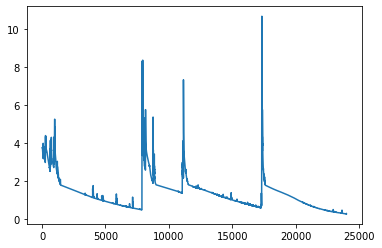

0.25537607073783875


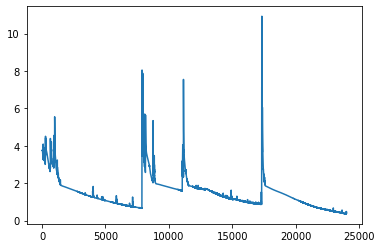

0.3547251224517822


In [9]:
plt.plot(losses)
plt.show()
print(min(losses))

plt.plot(test_losses)
plt.show()
print(min(test_losses))

89/100


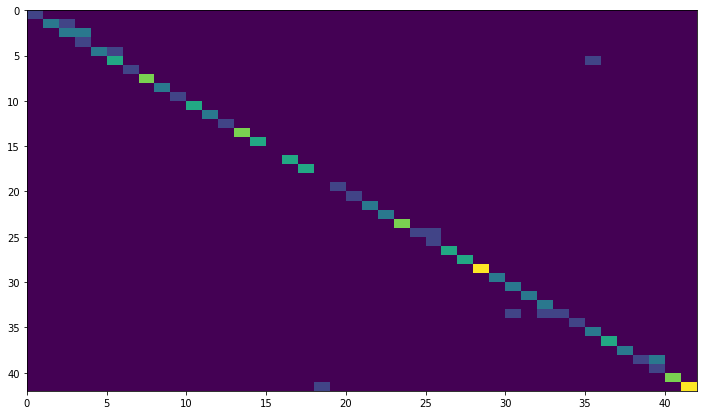

In [33]:
# Calc confusion matrix over test data set
din, trial_end, trial_len, dout, dlabel = next(iter(loader_test))

batch_size = din.shape[0]
steps = din.shape[1]

mike.reset()
model.reset()

pred = unroll(model, mike, observer, din, cuda=CUDA)


correct = 0
confusion_matrix = torch.zeros(42, 42)
for x in range(batch_size):
    m = torch.argmax(pred[x, :])
    if m == dlabel[x]:
        correct += 1
        
    confusion_matrix[dlabel[x], m] += 1.0
print(f"{correct}/{batch_size}")

#confusion_matrix /= confusion_matrix.sum(axis=1)

plt.figure(figsize = (12,7))
plt.gca().invert_yaxis()
plt.pcolormesh(confusion_matrix)